# Phase 2 (2.1, 2.2, 2.3
2.1 Sira a Babak
2.2 Sira
2.3 Babak

## Imports, data loading (from phase 1)

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
import math
import pandas as pd

 
from matplotlib import pyplot as plt

We decided to not use one-shot encoding for any of the columns because we lack domain specific knowledge and do not know all possible value of any categorical column - ie, we cannot be sure if the sets are closed.

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
base_dir = os.path.join("..")
dataset_dir = os.path.join(base_dir, "dataset")

connections_path = os.path.join(dataset_dir, "connections.csv")
devices_path = os.path.join(dataset_dir, "devices.csv")
processes_path = os.path.join(dataset_dir, "processes.csv")
profiles_path = os.path.join(dataset_dir, "profiles.csv")

In [4]:
connections = pd.read_csv(connections_path, date_format='%Y-%m-%d %H:%M:%S', parse_dates=["ts"], sep="\t")
devices = pd.read_csv(devices_path, sep="\t")
processes = pd.read_csv(processes_path, date_format='%Y-%m-%d %H:%M:%S', parse_dates=["ts"], sep="\t")
profiles = pd.read_csv(profiles_path, sep="\t")

### Data Preparation

We have made some changes from the faza1 and clean some data before Processing of data.

In [5]:
# The devices dataset is sorted by the store_name column, because we see a lot of duplicates with one Profile for many imei code.
# After sorting, it removes duplicate entries based on the imei column, keeping only the first occurrence of each unique imei value. 

devices = devices.sort_values(by='store_name', ascending=False)
devices = devices.drop_duplicates(subset='imei', keep="first")

In [6]:
profiles = profiles.rename(columns=lambda col: "prof." + col)
devices = devices.rename(columns=lambda col: "d." + col)

In [7]:
# Formatting data format function
def parse_date(date_str):
    date_formats = [
        "%d %b %Y",           # e.g., 12 Oct 2018
        "%Y/%m/%d",           # e.g., 2022/12/25
        "%Y-%m-%d",           # e.g., 2021-01-13
        "%m/%d/%Y, %H:%M:%S", # e.g., 05/12/2021, 00:00:00
        "%m/%d/%Y",           # e.g., 04/25/2023
        "%d %b %Y, %H:%M:%S", # e.g., 24 Aug 2023, 00:00:00
    ]
    for fmt in date_formats:
        try:
            return datetime.strptime(date_str, fmt).strftime("%Y-%m-%d")
        except ValueError:
            continue
        except TypeError:
            continue
    return None  # Return None if the date format is unrecognized


# Parse and convert 'registration' to datetime, coercing invalid entries to NaT
profiles['prof.registration'] = profiles['prof.registration'].apply(parse_date)
profiles['prof.birthdate'] = profiles['prof.birthdate'].apply(parse_date)

profiles['prof.registration'] = pd.to_datetime(profiles['prof.registration'], errors='coerce')
profiles['prof.birthdate'] = pd.to_datetime(profiles['prof.birthdate'], errors='coerce')

In [8]:
profiles['prof.birthdate']

0             NaT
1             NaT
2      2012-05-29
3             NaT
4             NaT
          ...    
2620   2003-08-28
2621   1989-07-22
2622          NaT
2623   1978-07-03
2624   1981-11-03
Name: prof.birthdate, Length: 2625, dtype: datetime64[ns]

In [9]:
# Remove dashes from 'ssn' and convert it to an integer
profiles['prof.ssn'] = profiles['prof.ssn'].str.replace('-', '', regex=False).astype("int64")

In [10]:
# Function to parse 'current_location' into latitude and longitude
def parse_location(location):
    if location == "Unknown" or pd.isnull(location):
        return None, None
    try:
        lat, lon = location[1:-1].split(", ")
        lat = float(lat.replace("Decimal('", "").replace("')", ""))
        lon = float(lon.replace("Decimal('", "").replace("')", ""))
        return lat, lon
    except:
        return None, None
    
    
# Apply 'parse_location' to split 'current_location' into new latitude and longitude columns
profiles[['prof.cur_loc_latitude', 'prof.cur_loc_longitude']] = profiles['prof.current_location'].apply(lambda x: pd.Series(parse_location(x)))

# Drop the original 'current_location' column after parsing
profiles = profiles.drop(columns=['prof.current_location'])

In [11]:
# Remove duplicate rows from each dataset to ensure unique entries
connections.drop_duplicates(inplace = True)
processes.drop_duplicates(inplace = True)
devices.drop_duplicates(inplace = True)
profiles.drop_duplicates(inplace = True)

We will count of occurrences for each unique imei, and show the distribution of these frequencies, indicating how many IMEIs appear with a specific repetition count. 
his helps identify the extent of duplication for imei values across profiles.

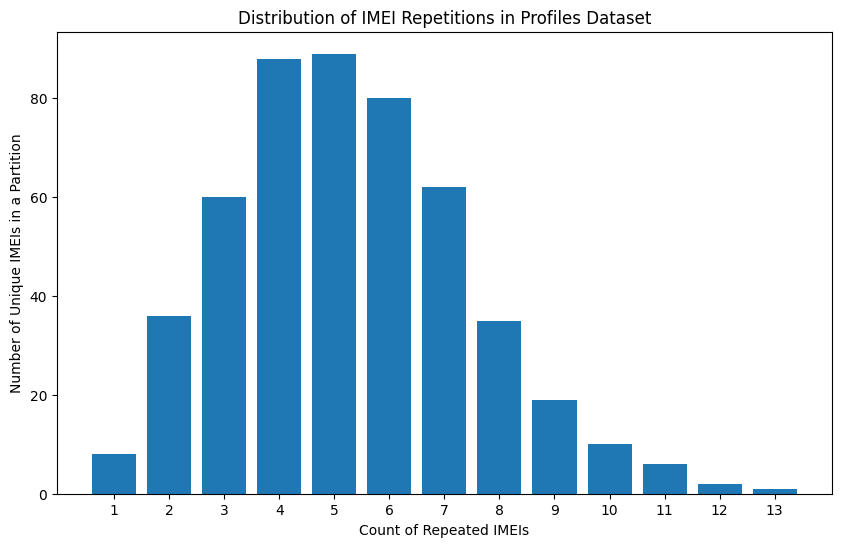

In [12]:
# Calculate imei repetition counts
imei_counts = profiles['prof.imei'].value_counts()

# Count of IMEI repetition frequencies (i.e., how many IMEIs have the same count)
count_of_counts = imei_counts.value_counts()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(count_of_counts.index, count_of_counts.values)
plt.xlabel('Count of Repeated IMEIs')
plt.ylabel('Number of Unique IMEIs in a Partition')
plt.title('Distribution of IMEI Repetitions in Profiles Dataset')
plt.xticks(count_of_counts.index)
plt.show()

This is a problem, because if we join it to the rest of the tables, we will overrepresent some entries
Out solution is to set repetetion to 7 - so all partition of < 7 entries would get duplicated, and all > 7 will be randomly
truncated

In [13]:
# Set the target number of rows per 'imei' value.
target_count = 3

# Function to balance rows for each 'imei'
def balance_imei_rows(group):
    count = len(group)
    if count > target_count:
        # If the group has more rows than the target, randomly sample down to the target count.
        return group.sample(target_count, random_state=1)  
    else:
        # If the group has fewer rows, duplicate rows to reach the target count.
        repeats = target_count // count
        extra = target_count % count
        # Combine repeated rows with a sample for the remainder.
        balanced_group = pd.concat([group] * repeats + [group.sample(extra, random_state=1)])
        return balanced_group

# Apply the balancing function to each group and combine results
profiles = profiles.set_index('prof.imei').groupby('prof.imei', group_keys=False).apply(balance_imei_rows).reset_index()

So, now we are ensured that each imei group in profiles has exactly 7 rows by truncating excess rows or duplicating smaller groups to meet the target. It’s helpful for creating a balanced dataset by standardizing the number of entries per imei.

### Join datasets (2.1)
We will perform outer join between 'connections' and 'processes' on 'imei' and 'ts'. An outer join is used here to keep all matching and non-matching rows across both datasets.
Then we'll merge the result with 'devices' and 'profiles' on 'imei' using an inner join. This keeps only the rows where 'imei' exists in both merged_data and devices with profiles.

In [14]:
merged_pc = pd.merge(connections, processes, on=['imei', 'ts'], how='outer')
merged_pcd = pd.merge(merged_pc, devices.rename(columns={'d.imei': 'imei'}), on=['imei'], how='left')
merged_data = pd.merge(merged_pcd, profiles.rename(columns={'prof.imei': 'imei'}), on='imei', how='left')

In [15]:
# Combine 'mwra_x' and 'mwra_y' columns into a single 'mwra' column, prioritizing non-null values in 'mwra_x' using combine_first.
merged_data['o.mwra'] = merged_data['mwra_x'].combine_first(merged_data['mwra_y'])
# Drop the original 'mwra_x' and 'mwra_y' columns to remove redundancy now that they are combined into 'mwra'.
merged_data.drop(columns=['mwra_x', 'mwra_y'], inplace=True)

**Merging Strategy:**
Inner joins are used initially to ensure the final merged_data only contains fully matched rows across all datasets. This approach is efficient, especially when data completeness is more important than including all potential entries.

**Alternative with Left Joins:**
Left joins allow more entries to be retained, even if there are missing values in some columns. However, handling the resulting NaN values would require additional processing. The commented example demonstrates this approach, with the final print statement showing the number of rows with missing values in code and user_id.

Since only a small fraction of data is lost by using inner joins, this method is acceptable, balancing simplicity with minimal data loss.

Now let's merge the two mwra columns created from a merge operation, preserving only one consistent mwra column, and removes the redundant columns afterward. Then rename columns with adding .o like (other) for future analyzing. Also, we will drop useless columns. 

Also, we'll process and transform datetime columns in merged_data for feature extraction and standardization. This includes extracting hour, determining weekend status, converting dates to ordinal format, and renaming columns to maintain consistent naming conventions. 

There are many devices and profiles with the same imei. We can do nothing about multiple devices, so it multiplies everything. But! We can do something about profiles. 
This is invalid for ts to be less then registration for joined row - how can you generate data before you even registered? 
We will replace bad profiles with mean info.

This code cleans up invalid profile data (where activity timestamps are before registration dates) by replacing invalid values with average values derived from valid profiles. It ensures consistency and prevents logically impossible data (e.g., generating data before registering) from skewing the dataset. Duplication is purposefully retained to handle multiple profiles for the same IMEI.

In [16]:
# Identify rows with invalid profiles by checking if 'registration' is before or equal to 'ts'
# (i.e., the timestamp of the activity should not be earlier than the registration date).
invalid_profiles_idx = merged_data['prof.registration'] > merged_data['ts']


In [17]:
invalid_profiles_idx.sum()

np.int64(40378)

In [18]:
(~invalid_profiles_idx).sum()

np.int64(4019)

As we can see, out heuristic can reduce the size of valid profiles*activity to <10000 elements. But still cannot be sure that some profile is 1-1 to some acitity. So we will instead mark invalid profiles as NA and impute them later, to not lose original relationships of processess/connections.

In [19]:

# Set the specified columns to NaN for invalid profiles in a single step
# intersect merged_data and profiles dataframes's columns 
merged_data.loc[invalid_profiles_idx, [c for c in profiles.columns if c in merged_data.columns]] = pd.NA

# Note: Duplicate rows are intentionally left intact to handle multiple profile records with the same IMEI,
# so we do not drop duplicates here. The duplication addresses multiple profiles tied to the same IMEI.
# # combined = combined2.drop_duplicates()


### Splitting data

In [20]:
# from sklearn.model_selection import train_test_split

# # Define the split ratio (e.g., 80% for training, 20% for testing)
# train_ratio = 0.8

# # Split the data
# train_data, test_data = train_test_split(merged_data, test_size=1 - train_ratio, random_state=1)

In [21]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=2343)
train_indices, test_indices = next(splitter.split(merged_data, groups=merged_data['imei']))

train_data = merged_data.iloc[train_indices]
test_data = merged_data.iloc[test_indices]

total_size = len(merged_data)
train_ratio = len(train_data) / total_size
test_ratio = len(test_data) / total_size

print(f"Train set size: {len(train_data)} rows ({train_ratio:.2%} of total)")
print(f"Test set size: {len(test_data)} rows ({test_ratio:.2%} of total)")


Train set size: 35736 rows (80.49% of total)
Test set size: 8661 rows (19.51% of total)


In [22]:
# Ensure 'imei' is the column representing the groups in both datasets
assert 'imei' in train_data.columns, "'imei' column not found in train_data"
assert 'imei' in test_data.columns, "'imei' column not found in test_data"

# Extract unique 'imei' values from both datasets
train_imeis = set(train_data['imei'].unique())
test_imeis = set(test_data['imei'].unique())

# Verify that the two sets of 'imei' values are disjoint
assert train_imeis.isdisjoint(test_imeis), "Train and test datasets are not disjoint by 'imei'!"

print("Train and test datasets are disjoint by 'imei'.")


Train and test datasets are disjoint by 'imei'.


In [23]:
# Save the dataset to .csv
merged_data.to_csv('merged_data.csv', index=False)
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

Note: As we understood the task, merging is done before pipelines (as well as parsing, that is before merging), while imputing / preprocessing / predictions inside a pipeline. That validation of profiles can easely be moved to profiles, but we decided to not because it is a purely merging artefact, not something that inherent in data itself. So "not including merge in pipelines" -> "not including validation of merged profiles in pipelines". 

### Pipelines

The GridBinningTransformer class designed to transforme class bins latitude and longitude coordinates into grid cells based on specified numbers of bins for latitude (n_lat_bins) and longitude (n_lon_bins). It then calculates unique grid indices for both device and current locations, filling any missing values with the median grid index.

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class GridBinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lat_col, lon_col, grid_idx_col, n_lat_bins=16, n_lon_bins=8):
        self.n_lat_bins = n_lat_bins
        self.n_lon_bins = n_lon_bins
        self.lat_col = lat_col
        self.lon_col = lon_col
        self.grid_idx_col = grid_idx_col

    def fit(self, X, y=None):
        self.columns_ = [c for c in X.columns if c not in [self.lat_col, self.lon_col]]
        self.columns_ = self.columns_ + [self.grid_idx_col]
        return self 
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_
        
    def transform(self, X):
        # Copy the DataFrame to avoid modifying the original data
        X = X.copy()
        
        # Discretize latitude and longitude into bins for device and current location
        lat_bin = pd.cut(X[self.lat_col], bins=self.n_lat_bins, labels=False)
        lon_bin = pd.cut(X[self.lon_col], bins=self.n_lon_bins, labels=False)
        
        # Calculate unique grid index for each area
        X[self.grid_idx_col] = lat_bin * self.n_lon_bins + lon_bin
        
        # Drop intermediate columns if only grid indices are needed
        X.drop(columns=[self.lat_col, self.lon_col], inplace=True)
        
        return X

The LogTransformerWithZeroHandling class applies a log transformation to a specified column, replacing zero values with 1 to avoid undefined log(0).

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class LogTransformerWithZeroHandling(BaseEstimator, TransformerMixin):
    """
    A transformer that applies a log transformation, replacing zero values with one to avoid log(0).
    Useful for handling columns where log transformation is desired but contains zeros.
    """
    def __init__(self):
        pass
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_
        
    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self

    def transform(self, X):
        X = X.copy() 
        X[X == 0] = 1 
        X = X.apply(np.log)
        
        return X

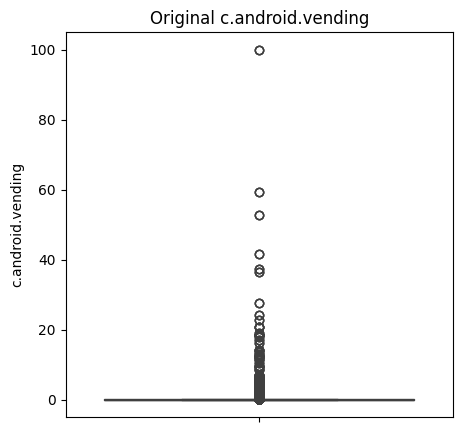

In [26]:
# We have notice bad data for this attribute: c.adroid.vending looks logarithmic
# Draw boxplot for the 'c.android.vending' column
plt.figure(figsize=(5, 5))
sns.boxplot(data=train_data, y='c.android.vending')
plt.title("Original c.android.vending")
plt.show()

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class ClippingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=5, upper_percentile=95):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_

    def fit(self, X, y=None):
        # Calculate the percentiles for each feature
        self.columns_ = X.columns
        self.lower_bounds_ = np.percentile(X, self.lower_percentile, axis=0)
        self.upper_bounds_ = np.percentile(X, self.upper_percentile, axis=0)
        return self

    def transform(self, X):
        # Clip the data within the calculated percentiles
        X_clipped = np.clip(X, self.lower_bounds_, self.upper_bounds_)
        return X_clipped


The DataProcessingTransformer class is a custom sklearn transformer designed to preprocess a DataFrame by performing several feature transformations on date-related columns and memory optimizations for numeric columns. It ensures consistency across date formats and derives useful features like hour and weekend indicators.

In [28]:
class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_
        
    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            X[col] = pd.to_datetime(X[col]).map(lambda x: x.toordinal())
        
        return X

In [29]:
class ColumnsDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.to_drop = columns
        self.columns = columns
        pass

    def fit(self, X, y=None):
        self.out_columns_ = [ c for c in X.columns if c not in self.to_drop ]
        return self
    
    def get_feature_names_out(self, *args, **params):
        return self.out_columns_
        
    def transform(self, X):
        # Ensure the input is a DataFrame
       return X.drop(columns = self.to_drop)

In [30]:
class IsNaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
        pass

    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_
        
    def transform(self, X):
        X = X.copy()
        X[self.col] = X[self.col].isna().astype("int8")
        return X

In [31]:
class DateImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
        self.fill_values = {}
        
    def get_feature_names_out(self, *args, **params):
        return self.columns_
        
    def fit(self, X, y=None):
        self.columns_ = X.columns
        for col in X.columns:
            if self.strategy == 'median':
                self.fill_values[col] = pd.to_datetime(X[col]).median()
            elif self.strategy == 'mean':
                self.fill_values[col] = pd.to_datetime(X[col]).mean()
            else:
               raise ValueError("Strategy not supported. Use 'median' or 'mean'.")
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill_values)

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class BinaryEncoder(BaseEstimator, TransformerMixin):
    """
    BinaryEncoder encodes categorical columns into binary representation.
    It transforms each unique category into its binary representation and splits
    the binary digits into separate columns.
    """

    def __init__(self):
        self.mapping = {}
        self.column_names = []

    def fit(self, X, y=None):
        """
        Learn the mapping of categories to binary codes.
        """
        self.mapping = {}
        self.column_names = []

        for col in X.columns:
            # Get the unique values and map them to integers
            categories = pd.Series(X[col].unique()).sort_values().reset_index(drop=True)
            self.mapping[col] = {
                'categories': categories,
                'codes': {cat: idx for idx, cat in enumerate(categories)}
            }

            # Determine the number of bits needed for binary representation
            n_bits = int(np.ceil(np.log2(len(categories) + 1)))
            self.column_names.extend([f"{col}_bin_{i}" for i in range(n_bits)])

        return self

    def transform(self, X):
        """
        Apply the binary encoding to the input data.
        """
        X = X.copy()
        binary_encoded = []

        for col in X.columns:
            # Map categories to integer codes
            codes = X[col].map(self.mapping[col]['codes']).fillna(0).astype(int).to_numpy()

            # Convert integer codes to binary representation
            n_bits = len(self.mapping[col]['categories']).bit_length()
            binary_matrix = ((codes[:, None] & (1 << np.arange(n_bits))) > 0).astype(int)
            binary_matrix_df = pd.DataFrame(binary_matrix, 
                                            columns=[f"{col}_bin_{i}" for i in range(n_bits)], 
                                            index=X.index)  # Ensure index alignment
            binary_encoded.append(binary_matrix_df)

        # Concatenate binary columns
        binary_encoded = pd.concat(binary_encoded, axis=1)
        return binary_encoded

    def get_feature_names_out(self, input_features=None):
        """
        Return the names of the output features.
        """
        return self.column_names


In [33]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder

class SafeOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = None  # Will initialize after fitting
        self.unknown_token = "Unknown"  # Define the unknown token

    def fit(self, X, y=None):
        # Convert NaNs to "Unknown" during fit
        if isinstance(X, pd.DataFrame):
            X = X.fillna(self.unknown_token)
        elif isinstance(X, np.ndarray):
            X = np.where(pd.isna(X), self.unknown_token, X)

        # Fit the underlying encoder
        self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        self.encoder.fit(X)
        return self

    def transform(self, X):
        # Convert NaNs to "Unknown" before transformation
        if isinstance(X, pd.DataFrame):
            X = X.fillna(self.unknown_token)
        elif isinstance(X, np.ndarray):
            X = np.where(pd.isna(X), self.unknown_token, X)

        # Replace unknown values with "Unknown"
        if isinstance(X, pd.DataFrame):
            for col_idx, col_name in enumerate(X.columns):
                known_categories = self.encoder.categories_[col_idx]
                X[col_name] = X[col_name].apply(
                    lambda val: val if val in known_categories else self.unknown_token
                )
        else:
            for col_idx in range(X.shape[1]):
                known_categories = self.encoder.categories_[col_idx]
                X[:, col_idx] = np.where(
                    np.isin(X[:, col_idx], known_categories), X[:, col_idx], self.unknown_token
                )

        return self.encoder.transform(X)

    def inverse_transform(self, X):
        return self.encoder.inverse_transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.encoder.get_feature_names_out(input_features)


In [34]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class SafeOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = None  # Will initialize after fitting
        self.unknown_token = "Unknown"  # Define the unknown token

    def fit(self, X, y=None):
        # Convert NaNs to "Unknown" during fit
        if isinstance(X, pd.DataFrame):
            X = X.fillna(self.unknown_token)
        elif isinstance(X, np.ndarray):
            X = np.where(pd.isna(X), self.unknown_token, X)

        # Fit the underlying encoder
        self.encoder = OneHotEncoder(handle_unknown="ignore")
        self.encoder.fit(X)
        return self

    def transform(self, X):
        # Convert NaNs to "Unknown" before transformation
        if isinstance(X, pd.DataFrame):
            X = X.fillna(self.unknown_token)
        elif isinstance(X, np.ndarray):
            X = np.where(pd.isna(X), self.unknown_token, X)

        # Replace unknown values with "Unknown"
        if isinstance(X, pd.DataFrame):
            for col_idx, col_name in enumerate(X.columns):
                known_categories = self.encoder.categories_[col_idx]
                X[col_name] = X[col_name].apply(
                    lambda val: val if val in known_categories else self.unknown_token
                )
        else:
            for col_idx in range(X.shape[1]):
                known_categories = self.encoder.categories_[col_idx]
                X[:, col_idx] = np.where(
                    np.isin(X[:, col_idx], known_categories), X[:, col_idx], self.unknown_token
                )

        return self.encoder.transform(X)

    def inverse_transform(self, X):
        return self.encoder.inverse_transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.encoder.get_feature_names_out(input_features)


In [35]:
pcs = [col for col in train_data.columns if col.startswith('p.') or col.startswith('c.')] # all attributes from processing and connection dataset

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer

preprocessing_pipeline = Pipeline([
    ('drop_columns', ColumnsDropper([
        "imei", "prof.user_id", "prof.ssn", "d.store_name", 
        "prof.username", "prof.mail", "prof.name", 
        "prof.address", "d.location"
    ])),
    
    ('fill_missing', ColumnTransformer(
        transformers=[
            ('birthdate_imputer', DateImputer(strategy='median'), ['prof.birthdate']),
            ('registration_imputer', DateImputer(strategy='mean'), ['prof.registration']),
            ('latitude_imputer_prof', SimpleImputer(strategy='mean'), ['prof.cur_loc_latitude']),
            ('longitude_imputer_prof', SimpleImputer(strategy='mean'), ['prof.cur_loc_longitude']),
            ('latitude_imputer_d', SimpleImputer(strategy='mean'), ['d.latitude']),
            ('longitude_imputer_d', SimpleImputer(strategy='mean'), ['d.longitude']),
            ('residence_imputer', SimpleImputer(strategy='constant', missing_values=pd.NA, fill_value=0.0), ['prof.residence']),
        ],
        remainder='passthrough', verbose_feature_names_out=False
    )),

    ('categorical_encoding_with_imputing', ColumnTransformer([
        ('categorical_encoding_code', SafeOrdinalEncoder(), ["d.code"]),
        ('categorical_encoding_company', SafeOrdinalEncoder(), ["prof.company"]),
    ], remainder='passthrough', verbose_feature_names_out=False)), 

    ('flag_missing_residence', IsNaTransformer('prof.residence')),

    ('grid_dev_locations', GridBinningTransformer('d.latitude', 'd.longitude', 'd.dev_loc_grid_idx', 16, 8)),
    ('grid_prof_locations', GridBinningTransformer('prof.cur_loc_latitude', 'prof.cur_loc_longitude', 'prof.cur_loc_grid_idx', 16, 8)),

    ('scale_transform', ColumnTransformer([
        ('log_transform_vending', LogTransformerWithZeroHandling(), ['c.android.vending']),
        ('dates', DateTransformer(), ['prof.birthdate', 'prof.registration', 'ts']),
    ], remainder='passthrough', verbose_feature_names_out=False)), 
    
    ('scale_transform_phase_2', ColumnTransformer([
        ('clipping', ClippingTransformer(lower_percentile=5, upper_percentile=95), pcs), # depends on "log_transform_vending"
        ('minmax', MinMaxScaler(), ["prof.birthdate"]), # depends on "dates"
    ], remainder='passthrough', verbose_feature_names_out=False)), 
    
    ('scale_transform_phase_3', ColumnTransformer([
        ('scaling_pcs', RobustScaler(), pcs), # depens on "clipping"
    ], remainder='passthrough', verbose_feature_names_out=False))
])

transformed_data = preprocessing_pipeline.set_output(transform="pandas").fit_transform(train_data)

In [37]:
transformed_data.to_csv("transformed_data.csv", index=False)

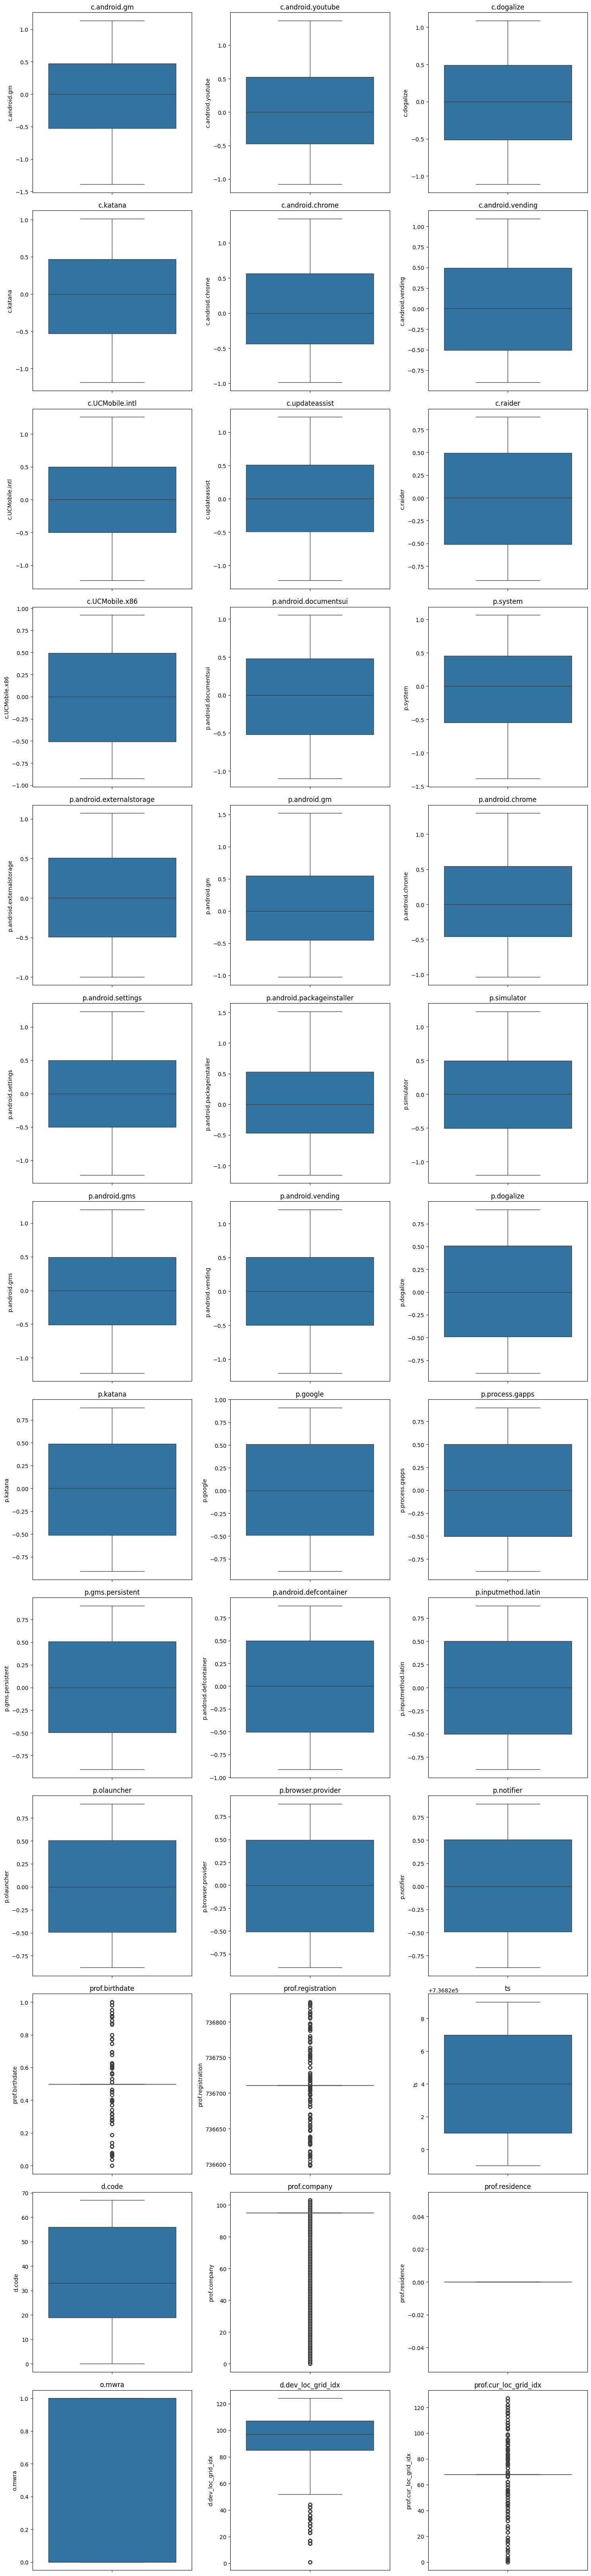

In [38]:

columns = transformed_data.columns
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), squeeze=False)

for i, col in enumerate(columns):
    row, col_num = divmod(i, n_cols)
    sns.boxplot(data=transformed_data, y=col, ax=axes[row][col_num])
    axes[row][col_num].set_title(col)

for j in range(i + 1, n_rows * n_cols):
    row, col_num = divmod(j, n_cols)
    fig.delaxes(axes[row][col_num])

plt.tight_layout()
plt.show()

# 2.2 (A, B, C)

### Aribute selection for machine learning

This code uses a Random Forest classifier to identify the most informative features for predicting a target variable. The data is split into features (X) and target (y), and a Random Forest model is trained on this data. After training, the feature importances—indicating each feature’s predictive power—are extracted, sorted, and displayed. 

Model performance is evaluated using accuracy and AUROC, providing metrics for classification quality. 

A horizontal bar plot visually highlights the most influential features, emphasizing those with the highest importance for interpretation.

In [39]:
from sklearn.ensemble import RandomForestClassifier

df = transformed_data.copy()
X = transformed_data.drop(columns=['o.mwra']) 
y = transformed_data['o.mwra']

model = RandomForestClassifier(random_state=42) 
model.fit(X, y)

# Get the importance of the traits
importances = model.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Desc sort
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the importance table
print(feature_importance)

                       Feature  Importance
4             c.android.chrome    0.139705
14            p.android.chrome    0.126107
10       p.android.documentsui    0.125547
5            c.android.vending    0.107841
16  p.android.packageinstaller    0.063739
0                 c.android.gm    0.045371
11                    p.system    0.037752
13                p.android.gm    0.032111
1            c.android.youtube    0.031874
12   p.android.externalstorage    0.026918
2                   c.dogalize    0.022703
3                     c.katana    0.020622
15          p.android.settings    0.015338
9               c.UCMobile.x86    0.011057
8                     c.raider    0.011036
17                 p.simulator    0.010862
26         p.inputmethod.latin    0.010719
19           p.android.vending    0.010585
6              c.UCMobile.intl    0.010486
25      p.android.defcontainer    0.010460
22                    p.google    0.010387
29                  p.notifier    0.010380
27         

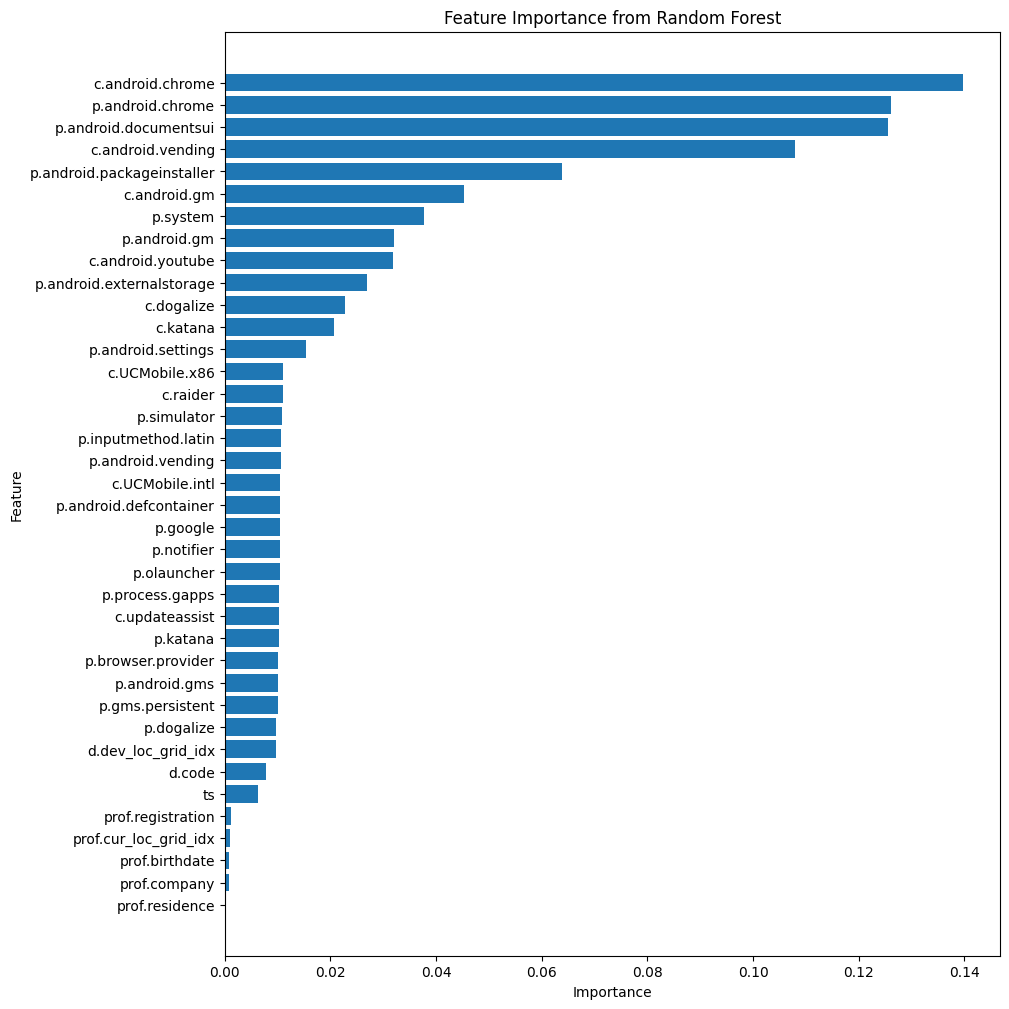

In [40]:
# Plot the graph
plt.figure(figsize=(10, 12))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


The evaluation shows perfect accuracy (1.0) and AUROC (1.0), indicating that the model classifies all samples correctly on the training data, which suggests potential overfitting since these scores might not generalize well to unseen data. Feature importance highlights that attributes like c.android.youtube, p.android.externalstorage, and p.android.documentsui are the most predictive, while features like o.birthdate and m.name_spaces have minimal impact, suggesting they contribute little to the model’s decisions.

### Mutual information

Mutual information is a metric that quantifies the dependency between two variables. In machine learning, mutual information measures how much knowing a feature reduces uncertainty about the target variable. Higher values indicate a stronger association, helping to identify the most informative features for prediction.


In [41]:
from sklearn.feature_selection import mutual_info_classif

X = transformed_data.drop(columns=['o.mwra']) 
y = transformed_data['o.mwra']
mi = mutual_info_classif(X, y, random_state=6389)

# Create a DataFrame for easy presentation of the results
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
})

# Sort the attributes by the value of mutual information in descending order
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display the importance table
print(mi_df)

                       Feature  Mutual Information
10       p.android.documentsui            0.279495
4             c.android.chrome            0.279173
14            p.android.chrome            0.259475
5            c.android.vending            0.250178
0                 c.android.gm            0.173989
11                    p.system            0.162183
16  p.android.packageinstaller            0.159969
13                p.android.gm            0.157761
1            c.android.youtube            0.155510
2                   c.dogalize            0.151365
20                  p.dogalize            0.124186
15          p.android.settings            0.120291
21                    p.katana            0.120126
22                    p.google            0.116646
19           p.android.vending            0.115150
28          p.browser.provider            0.112903
27                 p.olauncher            0.112569
18               p.android.gms            0.112282
23             p.process.gapps 

Features like c.android.youtube, p.android.externalstorage, and p.android.documentsui have the highest mutual information scores (above 0.6), indicating strong relevance to the target variable. This aligns with the Random Forest importance rankings, confirming them as key predictors. In contrast, features with low scores, such as o.cur_loc_grid_idx (0.000), o.birthdate, and o.hour, show minimal to no contribution, suggesting they may be unnecessary for the model and could be safely excluded.

### Logistic Regression
Another way to identify informative features is to use the coefficients of a linear model, such as with logistic regression. Logistic regression evaluates each feature by assigning it a coefficient that indicates how much influence the feature has on the model's predictions.

In [42]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

X = transformed_data.drop(columns=['o.mwra']) 
y = transformed_data['o.mwra']

model = LogisticRegression(max_iter=5000, random_state=3883) 
model.fit(X, y)

coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs() 

coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df)


                       Feature  Coefficient  Abs_Coefficient
14            p.android.chrome    -1.432120         1.432120
4             c.android.chrome    -1.222531         1.222531
16  p.android.packageinstaller    -0.787104         0.787104
11                    p.system    -0.571193         0.571193
0                 c.android.gm     0.503710         0.503710
10       p.android.documentsui     0.432671         0.432671
3                     c.katana     0.409230         0.409230
5            c.android.vending     0.368102         0.368102
2                   c.dogalize    -0.319425         0.319425
12   p.android.externalstorage    -0.317075         0.317075
15          p.android.settings     0.312164         0.312164
13                p.android.gm     0.309048         0.309048
1            c.android.youtube     0.271419         0.271419
6              c.UCMobile.intl    -0.100771         0.100771
28          p.browser.provider    -0.098973         0.098973
21                    p.

This table presents feature coefficients from a linear model, indicating the direction and magnitude of each feature's impact on the target variable. Positive coefficients suggest that as the feature value increases, the probability of the target class increases, while negative coefficients imply the opposite.

Key features like c.android.youtube (coefficient of 0.91), p.android.externalstorage (-0.86), and p.android.documentsui (-0.86) show strong influence, with high absolute values. This aligns with previous analyses, confirming their predictive relevance. On the other hand, features such as o.company, o.birthdate, and o.registration have coefficients close to zero, meaning they contribute minimally to the model's predictions and may not significantly affect the target.

In [43]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression

# Step 1: Random Forest Feature Importances
rf_model = RandomForestClassifier(criterion='entropy', max_depth=None, max_features='sqrt', n_estimators=70, random_state=42)
rf_model.fit(X, y)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf_model.feature_importances_
}).sort_values(by='RF_Importance', ascending=False)

# Step 2: Mutual Information
mi = mutual_info_classif(X, y)
mi_importance = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi
}).sort_values(by='MI_Score', ascending=False)

# Step 3: Logistic Regression Coefficients
lr_model = LogisticRegression(max_iter=5000, random_state=7474)
lr_model.fit(X, y)
lr_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'LR_Coefficient': lr_model.coef_[0],
    'Abs_LR_Coefficient': abs(lr_model.coef_[0])
}).sort_values(by='Abs_LR_Coefficient', ascending=False)

# Step 4: Merge results
feature_comparison = rf_importance.merge(mi_importance, on='Feature').merge(lr_coefficients, on='Feature')

# Display the comparison table
print(feature_comparison)


                       Feature  RF_Importance  MI_Score  LR_Coefficient  \
0             c.android.chrome       0.118525  0.279188       -1.222531   
1        p.android.documentsui       0.106687  0.280597        0.432671   
2             p.android.chrome       0.104931  0.260453       -1.432120   
3            c.android.vending       0.103320  0.250100        0.368102   
4   p.android.packageinstaller       0.054542  0.158720       -0.787104   
5                 c.android.gm       0.043906  0.173821        0.503710   
6                     p.system       0.038399  0.161754       -0.571193   
7            c.android.youtube       0.034839  0.155555        0.271419   
8    p.android.externalstorage       0.031505  0.108619       -0.317075   
9                 p.android.gm       0.030432  0.156761        0.309048   
10                  c.dogalize       0.026907  0.152625       -0.319425   
11                    c.katana       0.024705  0.109856        0.409230   
12          p.android.set

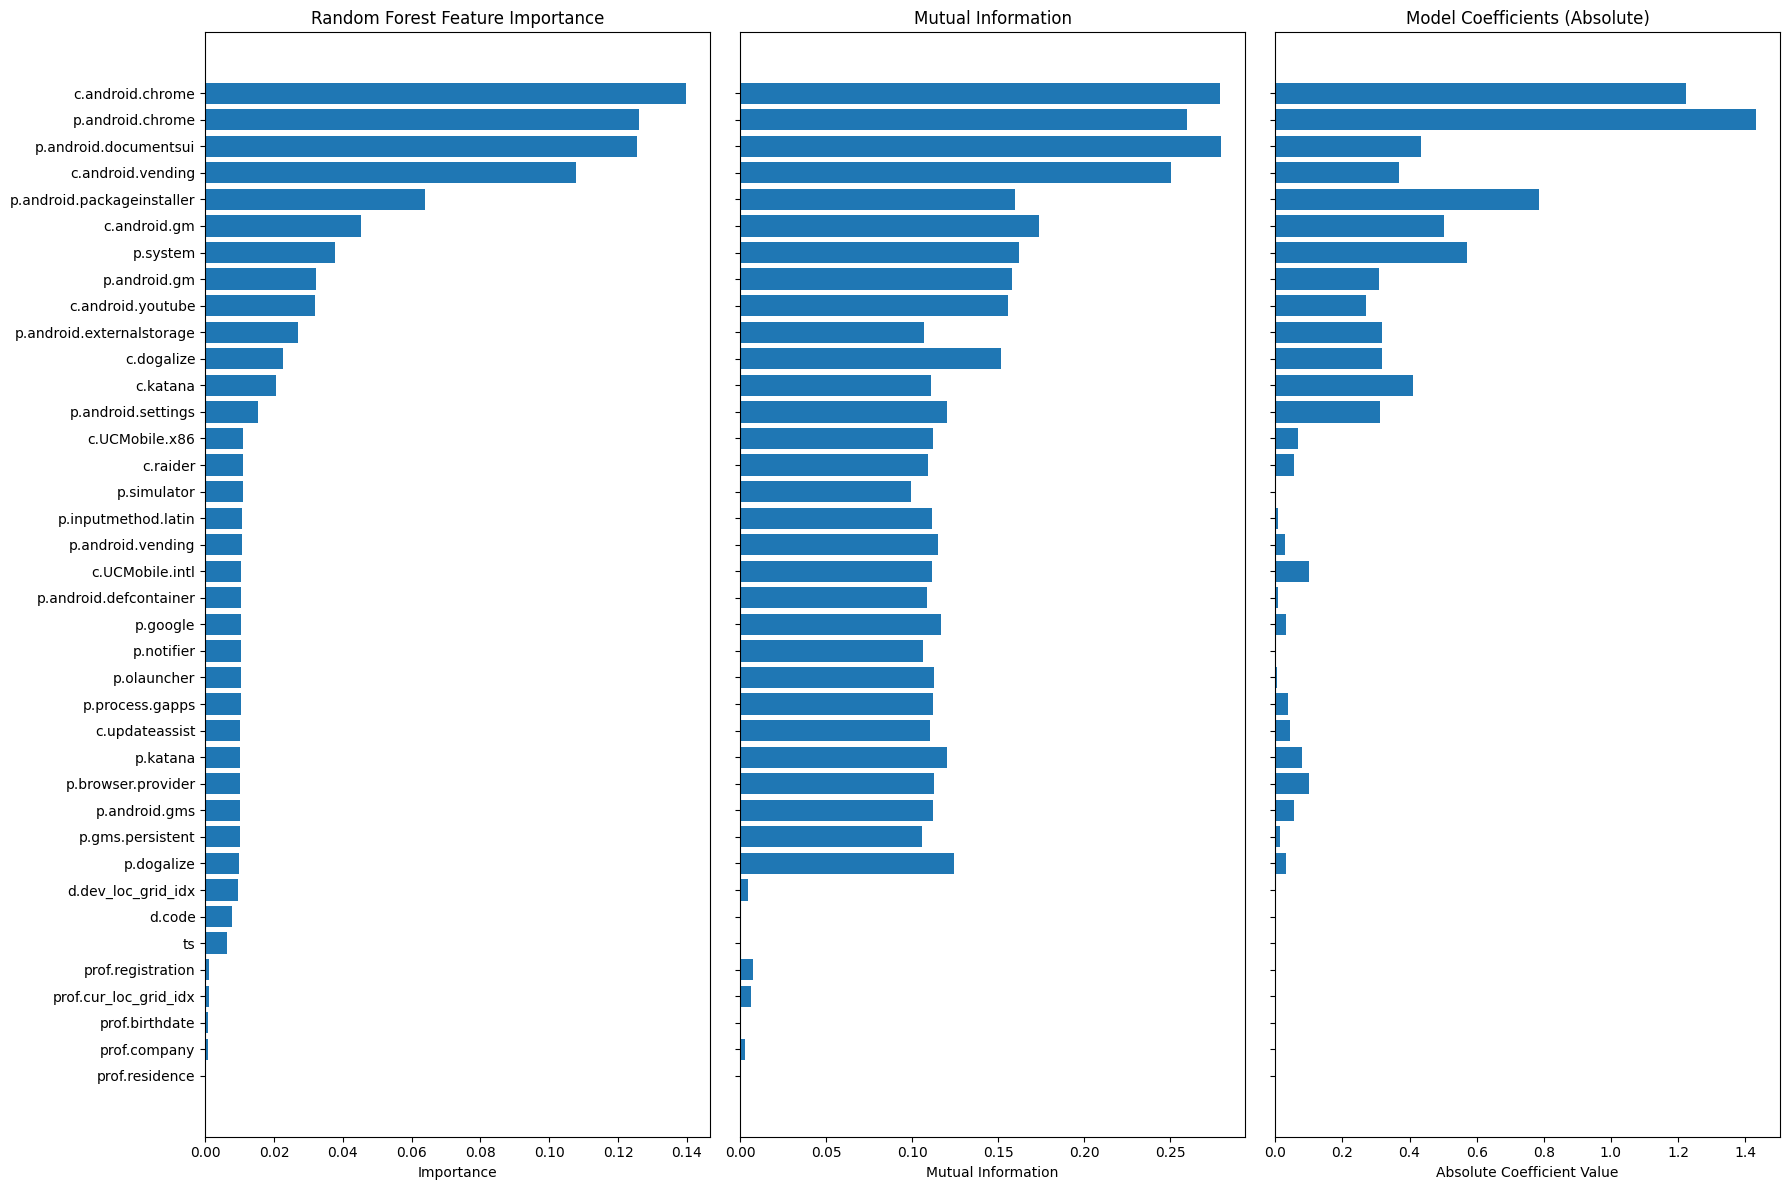

In [44]:
import matplotlib.pyplot as plt

# Sort feature importance DataFrames to ensure consistency across plots
rf_importance = feature_importance.sort_values(by='Importance', ascending=False)
mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Set up the plot canvas
fig, axs = plt.subplots(1, 3, figsize=(18, 12), sharey=True)

# Random Forest Feature Importance plot
axs[0].barh(rf_importance['Feature'], rf_importance['Importance'])
axs[0].set_title('Random Forest Feature Importance')
axs[0].invert_yaxis()  # For descending order
axs[0].set_xlabel('Importance')

# Mutual Information plot
axs[1].barh(mi_df_sorted['Feature'], mi_df_sorted['Mutual Information'])
axs[1].set_title('Mutual Information')
axs[1].invert_yaxis()
axs[1].set_xlabel('Mutual Information')

# Model Coefficients plot (absolute values)
axs[2].barh(coef_df_sorted['Feature'], coef_df_sorted['Abs_Coefficient'])
axs[2].set_title('Model Coefficients (Absolute)')
axs[2].invert_yaxis()
axs[2].set_xlabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()


Top Predictive Features: Across all methods, certain features like c.android.youtube, p.android.externalstorage, and p.android.documentsui consistently appear as highly informative. These features show high importance in both Random Forest and mutual information methods and have large coefficients, indicating they strongly influence the target variable (o.mwra). Their consistent ranking across methods suggests they are crucial for predicting outcomes in this dataset.

Low-Impact Features: Features such as prof.birthdate, prof.residence, and prof.company appear at the bottom of all rankings. Their low scores across all methods indicate that they contribute minimally to predicting the target variable and could potentially be removed to simplify the model without significantly impacting accuracy.

- p.android.chrome (because all three metrics show its importance)
- c.android.chrome (because all three metrics show it's importance)
- p.android.documentsui (because in 2 of 3 metrics it is next important)
- p.android.packageinstaller ( reasoning is the same as in previous cases )
- p.android.vending ( reasoning is the same as in previous cases )
- p.android.gm ( reasoning is the same as in previous cases )
- ...



### Final pipeline

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, random_state=42):
        self.top_n = top_n
        self.random_state = random_state
        self.selected_features = None

    def fit(self, X, y=None):
        # Handle case where target 'o.mwra' is in the data
        if y is None:
            y = X['o.mwra']
            X = X.drop(columns=['o.mwra'])

        # Random Forest for feature importance
        rf_model = RandomForestClassifier(criterion='entropy', max_depth=None, max_features='sqrt', 
                                          n_estimators=70, random_state=self.random_state)
        rf_model.fit(X, y)
        rf_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        # Select the top features
        self.selected_features = rf_importance.head(self.top_n)['Feature'].tolist()
        self.selected_features.append("o.mwra")  # Ensure target column is retained
        # self.selected_features.append("prof.residence") 
        self.columns_ = self.selected_features
        
        return self

    def transform(self, X):
        # Ensure the input is a DataFrame and validate selected features
        valid_features = [feature for feature in self.selected_features if feature in X.columns]
        if not valid_features:
            raise ValueError("No valid features selected. Check feature selection logic.")
        return X[valid_features]

    def get_feature_names_out(self, *args, **kwargs):
        return self.columns_

# Define pipeline with the updated FeatureSelector
preprocessing_pipeline2 = Pipeline([
    ('previous_preprocessing', preprocessing_pipeline),
    ('feature_selection', FeatureSelector(top_n=100, random_state=42)),
])


## Replicability of preprocessing (2.3)

In [46]:
transformed_data = preprocessing_pipeline2.set_output(transform="pandas").fit_transform(train_data)
transformed_test_data = preprocessing_pipeline2.set_output(transform="pandas").transform(test_data)
transformed_test_data

,c.android.chrome,p.android.documentsui,p.android.chrome,c.android.vending,p.android.packageinstaller,c.android.gm,p.system,c.android.youtube,p.android.externalstorage,p.android.gm,c.dogalize,c.katana,p.android.settings,p.inputmethod.latin,p.google,p.simulator,p.android.vending,c.raider,c.UCMobile.intl,p.browser.provider,c.updateassist,p.android.gms,c.UCMobile.x86,p.android.defcontainer,p.olauncher,p.process.gapps,p.notifier,p.gms.persistent,p.katana,p.dogalize,d.dev_loc_grid_idx,d.code,ts,prof.registration,prof.cur_loc_grid_idx,prof.company,prof.birthdate,prof.residence,o.mwra
543,-0.160809,0.253030,-1.032048,0.260448,0.896353,-0.397347,-1.388895,-0.490444,-0.079899,1.189412,-0.799109,-0.300931,0.411686,0.583809,-0.704846,-0.258132,-0.732073,0.804264,-0.913436,0.215997,0.901329,-1.069953,0.556650,-0.312834,-0.108366,-0.561065,0.604580,-0.507024,0.466953,-0.278753,105,63.0,736820,736711,68,95.0,0.496879,0,1.0
544,-0.160809,0.253030,-1.032048,0.260448,0.896353,-0.397347,-1.388895,-0.490444,-0.079899,1.189412,-0.799109,-0.300931,0.411686,0.583809,-0.704846,-0.258132,-0.732073,0.804264,-0.913436,0.215997,0.901329,-1.069953,0.556650,-0.312834,-0.108366,-0.561065,0.604580,-0.507024,0.466953,-0.278753,105,63.0,736820,736711,68,95.0,0.496879,0,1.0
545,-0.160809,0.253030,-1.032048,0.260448,0.896353,-0.397347,-1.388895,-0.490444,-0.079899,1.189412,-0.799109,-0.300931,0.411686,0.583809,-0.704846,-0.258132,-0.732073,0.804264,-0.913436,0.215997,0.901329,-1.069953,0.556650,-0.312834,-0.108366,-0.561065,0.604580,-0.507024,0.466953,-0.278753,105,63.0,736820,736711,68,95.0,0.496879,0,1.0
546,-0.651583,0.785573,0.383689,0.812564,-0.980558,1.122723,-0.651041,-0.147379,0.119209,-1.023450,-0.992195,-0.082188,1.234295,-0.603163,-0.230643,-0.804521,-0.049406,0.889313,0.603827,0.069966,-0.800185,0.411967,0.005391,-0.122671,-0.042348,-0.301157,-0.664883,0.760646,0.885146,0.733365,105,63.0,736821,736711,68,95.0,0.496879,0,1.0
547,-0.651583,0.785573,0.383689,0.812564,-0.980558,1.122723,-0.651041,-0.147379,0.119209,-1.023450,-0.992195,-0.082188,1.234295,-0.603163,-0.230643,-0.804521,-0.049406,0.889313,0.603827,0.069966,-0.800185,0.411967,0.005391,-0.122671,-0.042348,-0.301157,-0.664883,0.760646,0.885146,0.733365,105,63.0,736821,736711,68,95.0,0.496879,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44047,0.186436,-0.012742,-0.365617,-0.011394,0.670005,0.362437,-0.915646,0.198737,0.515278,1.520755,-0.645547,-0.181791,-0.814306,0.501293,-0.709971,-1.196102,0.574442,0.059644,-0.960495,0.136537,-0.724105,-0.418104,0.212111,0.029245,0.267849,0.565595,-0.548074,-0.068208,0.704190,0.104905,67,42.0,736828,736711,68,95.0,0.496879,0,1.0
44048,0.186436,-0.012742,-0.365617,-0.011394,0.670005,0.362437,-0.915646,0.198737,0.515278,1.520755,-0.645547,-0.181791,-0.814306,0.501293,-0.709971,-1.196102,0.574442,0.059644,-0.960495,0.136537,-0.724105,-0.418104,0.212111,0.029245,0.267849,0.565595,-0.548074,-0.068208,0.704190,0.104905,67,42.0,736828,736711,68,95.0,0.496879,0,1.0
44049,1.343242,0.068231,0.543228,0.070356,1.517750,-0.495351,0.693403,-0.318812,-0.910749,-0.109755,0.475024,0.145810,0.687661,0.851651,-0.326597,-1.196102,-0.803229,0.423547,0.985893,0.820916,0.282753,0.021850,-0.218263,0.269371,0.464926,-0.855546,0.893094,0.044334,-0.683710,0.098669,67,42.0,736829,736607,23,95.0,0.057171,0,0.0
44050,1.343242,0.068231,0.543228,0.070356,1.517750,-0.495351,0.693403,-0.318812,-0.910749,-0.109755,0.475024,0.145810,0.687661,0.851651,-0.326597,-1.196102,-0.803229,0.423547,0.985893,0.820916,0.282753,0.021850,-0.218263,0.269371,0.464926,-0.855546,0.893094,0.044334,-0.683710,0.098669,67,42.0,736829,736711,68,95.0,0.496879,0,0.0


In [47]:
# Save the dataset to .csv
transformed_test_data.to_csv('merged_data.csv', index=False)
transformed_data.to_csv("train_data.csv", index=False)

In [48]:
# Define the training data and target variable
X_train = transformed_data.drop(columns=['o.mwra'])
y_train = transformed_data['o.mwra']

# Split the test data into features and the target variable
X_test = transformed_test_data.drop(columns=['o.mwra'])
y_test = transformed_test_data['o.mwra']

# Faza 3

3.1 and 3.2 (50%) - Dariia Sira

3.3 and 3.4 (50%) - Babak Oleksandr

Note: We changed data splitting logic to `GroupShuffleSplit` on `imei` key, as naive random splitting resulted in data with same `imei` key in both train and test datasets. It shared more patterns between them, so our evaluations on test data were very close to those on test.

## 3.1 Simple classifier based on dependencies in the data

### 3.1A: DecisionTreeClassifier ID3 classifier with depth min 2 (including root/root). 

We are going to implement the ID3 algorithm to build a decision tree based on entropy and information gain. For this purpose, the data are pre-transformed into a categorical format so that the algorithm can correctly separate them based on feature values.

Categorization of the data is necessary to use the ID3 algorithm because it works with categorical features, and numerical values must be converted into discrete categories before calculating entropy and information gain. 

In the code below, the numerical data was divided into four ranges using the **pd.cut method**, where each range was assigned categories: __Low, Medium, High and Very High__. This allows for correct calculation of entropy and construction of a decision tree that meets the ID3 requirements. 

In [ ]:
# Discretize the entire train dataset except the target column
train_data_discret = transformed_data.copy()
train_data_discret.loc[:, train_data_discret.columns != 'o.mwra'] = train_data_discret.loc[
    :, train_data_discret.columns != 'o.mwra'
].apply(lambda col: pd.cut(col, bins=4, labels=['Low', 'Medium', 'High', 'Very High']))

# Discretize the entire test dataset except the target column
test_data_discret = transformed_test_data.copy()
test_data_discret.loc[:, test_data_discret.columns != 'o.mwra'] = test_data_discret.loc[
    :, test_data_discret.columns != 'o.mwra'
].apply(lambda col: pd.cut(col, bins=4, labels=['Low', 'Medium', 'High', 'Very High']))

# Define the training data and target variable
X_train_discret = train_data_discret.drop(columns=['o.mwra'])
y_train_discret = train_data_discret['o.mwra']

# Split the test data into features and the target variable
X_test_discret = test_data_discret.drop(columns=['o.mwra'])
y_test_discret = test_data_discret['o.mwra']

In [50]:
train_data_discret.head()

,c.android.chrome,p.android.documentsui,p.android.chrome,c.android.vending,p.android.packageinstaller,c.android.gm,p.system,c.android.youtube,p.android.externalstorage,p.android.gm,c.dogalize,c.katana,p.android.settings,p.inputmethod.latin,p.google,p.simulator,p.android.vending,c.raider,c.UCMobile.intl,p.browser.provider,c.updateassist,p.android.gms,c.UCMobile.x86,p.android.defcontainer,p.olauncher,p.process.gapps,p.notifier,p.gms.persistent,p.katana,p.dogalize,d.dev_loc_grid_idx,d.code,ts,prof.registration,prof.cur_loc_grid_idx,prof.company,prof.birthdate,prof.residence,o.mwra
0,Medium,Medium,High,Medium,Medium,Very High,Low,Low,High,High,Medium,High,High,Low,High,Medium,High,High,Medium,Very High,Very High,High,Medium,Medium,Low,Very High,Medium,Low,Very High,Low,Very High,Very High,Low,Medium,High,Very High,Medium,Medium,0.0
1,Medium,Medium,High,Medium,Medium,Very High,Low,Low,High,High,Medium,High,High,Low,High,Medium,High,High,Medium,Very High,Very High,High,Medium,Medium,Low,Very High,Medium,Low,Very High,Low,Very High,Very High,Low,Medium,High,Very High,Medium,Medium,0.0
2,Medium,Medium,High,Medium,Medium,Very High,Low,Low,High,High,Medium,High,High,Low,High,Medium,High,High,Medium,Very High,Very High,High,Medium,Medium,Low,Very High,Medium,Low,Very High,Low,Very High,Very High,Low,Medium,High,Very High,Medium,Medium,0.0
3,High,Medium,High,Medium,Low,Low,Medium,Medium,High,Low,High,Very High,High,High,Very High,High,High,High,Very High,High,Low,Medium,Low,Medium,Very High,Very High,Low,Very High,Medium,Low,Very High,Very High,Low,Medium,High,Very High,Medium,Medium,0.0
4,High,Medium,High,Medium,Low,Low,Medium,Medium,High,Low,High,Very High,High,High,Very High,High,High,High,Very High,High,Low,Medium,Low,Medium,Very High,Very High,Low,Very High,Medium,Low,Very High,Very High,Low,Medium,High,Very High,Medium,Medium,0.0


The table above is how new train and test datasets are. Let's continue with implementing of ID3 classificator. 

Information is inspired from https://www.geeksforgeeks.org/sklearn-iterative-dichotomiser-3-id3-algorithms/

Firstly calculate entropy for a dataset based on a specified target column. It starts by determining the total number of rows and unique values in the target column. Then, it iterates through these values, calculating the proportion of instances for each value and updating the entropy accordingly.

In [51]:
def entropy(data, target_column):
    total_rows = len(data) 
    target_values = data[target_column].unique() 
  
    entropy = 0
    for value in target_values: 
        # Calculate the proportion of instances with the current value 
        value_count = len(data[data[target_column] == value]) 
        proportion = value_count / total_rows 
        entropy -= proportion * math.log2(proportion) 
  
    return entropy

entropy_outcome = entropy(train_data_discret, 'o.mwra') 
print(f"Entropy of the dataset: {entropy_outcome}")

Entropy of the dataset: 0.9537092621793286


An entropy value of 0.95 indicates moderate uncertainty in the target data: the data is not perfectly partitioned, but has structure that the model can effectively use for classification.

The information_gain function calculates the information gain for a specified feature by computing the weighted average entropy of subsets created by splitting the data based on that feature. The final information gain is obtained by subtracting this weighted entropy from the overall entropy of the dataset. This approach helps assess the effectiveness of a feature in reducing uncertainty about the target variable.

In [52]:
def information_gain(data, feature, target_column):
    entropy_outcome = entropy(data, target_column)
    unique_values = data[feature].unique()
    weighted_entropy = 0

    for value in unique_values:
        subset = data[data[feature] == value]
        proportion = len(subset) / len(data)
        weighted_entropy += proportion * entropy(subset, target_column)

    information_gain = entropy_outcome - weighted_entropy

    return information_gain

# Calculate entropy of the target variable
target_column = 'o.mwra'

# Calculate information gain for each feature
for feature in X_train.columns:
    info_gain = information_gain(train_data_discret, feature, target_column)
    print(f"Information Gain for {feature}: {info_gain:.4f}")
    

Information Gain for c.android.chrome: 0.2750
Information Gain for p.android.documentsui: 0.2644
Information Gain for p.android.chrome: 0.2459
Information Gain for c.android.vending: 0.2662
Information Gain for p.android.packageinstaller: 0.0800
Information Gain for c.android.gm: 0.1010
Information Gain for p.system: 0.0697
Information Gain for c.android.youtube: 0.0602
Information Gain for p.android.externalstorage: 0.0003
Information Gain for p.android.gm: 0.0577
Information Gain for c.dogalize: 0.0602
Information Gain for c.katana: 0.0015
Information Gain for p.android.settings: 0.0020
Information Gain for p.inputmethod.latin: 0.0001
Information Gain for p.google: 0.0004
Information Gain for p.simulator: 0.0004
Information Gain for p.android.vending: 0.0002
Information Gain for c.raider: 0.0001
Information Gain for c.UCMobile.intl: 0.0003
Information Gain for p.browser.provider: 0.0004
Information Gain for c.updateassist: 0.0001
Information Gain for p.android.gms: 0.0004
Information

The results show which features are the most important for predicting the target variable. For example, `c.android.youtube` has the highest Information Gain, meaning it’s the best feature to split the data and reduce uncertainty at this step. On the other hand, features like `prof.birthdate` or `p.google` provide almost no useful information, so they likely won’t help in making accurate predictions. This means the decision tree will focus on the top features, like `c.android.youtube`, to create splits, while ignoring less useful ones. 

Once the ID3 algorithm has selected the attribute with the highest information gain, it splits the data set on that attribute. The data points with each value of the attribute are placed in a separate subset. The ID3 algorithm is then recursively applied to each subset, until all of the subsets are pure, meaning that all of the data points in each subset belong to the same category.

Note: I added regularization to restrict the tree to a minimum number of objects in each leaf (10 entries). This will limit the tree from being overly granular over small groups of data, which may reduce overfitting.

In [53]:
def id3(data, target_column, features, depth=0, max_depth=2, min_samples_split=10):
    # If all target values are the same, return that value
    if len(data[target_column].unique()) == 1:
        return data[target_column].iloc[0]

    # If depth reaches max_depth or number of samples is below min_samples_split, return the most common target value
    if depth >= max_depth or len(data) < min_samples_split or len(features) == 0:
        return data[target_column].mode().iloc[0]

    # Choose the best feature based on information gain
    best_feature = max(features, key=lambda x: information_gain(data, x, target_column))

    # Initialize the decision tree with the best feature as the root
    tree = {best_feature: {}}

    # Remove the best feature from the list of available features
    remaining_features = [f for f in features if f != best_feature]

    # Recursive call to build the tree for each unique value of the best feature
    for value in data[best_feature].unique():
        subset = data[data[best_feature] == value]
        # Increase depth by 1 for the next recursive call
        tree[best_feature][value] = id3(subset, target_column, remaining_features, depth + 1, max_depth, min_samples_split)

    return tree

In [54]:
# Preparing the data for training
features = list(X_train_discret.columns)      # List of feature names
target_column = 'o.mwra'

# Build the decision tree with depth limitation and minimum samples for split
decision_tree = id3(train_data_discret, target_column, features, max_depth=2, min_samples_split=10)

# Output the decision tree
# print("Decision Tree ID3:", decision_tree)

### 3.1B: ID3 classifier Evaluation 

This code predicts the target class for each sample in the dataset using the decision tree. It works by checking the feature values in a sample and following the paths in the tree until it reaches a final decision (a leaf). If the tree doesn’t have a path for a specific value, it assigns the most common class from the training data as the prediction, ensuring that every sample gets a result.

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get the most common class in y_train
most_common_class = y_train_discret.mode()[0]

# A function for prediction using the built tree
def predict(tree, sample):
    # If the node is the result, return it
    if not isinstance(tree, dict):
        return tree
    feature = next(iter(tree)) # Get the root node (the best feature)
    feature_value = sample[feature]
    if feature_value in tree[feature]:
        return predict(tree[feature][feature_value], sample)
    else:
        # If the feature value is not in the tree, return None
        return None

# A function for making predictions on the entire dataset with None processing
def make_predictions(tree, X):
    predictions = []
    for _, sample in X.iterrows():
        prediction = predict(tree, sample)
        # Replace None with the most frequent class if there is no prediction
        predictions.append(prediction if prediction is not None else most_common_class)
    return predictions

In [56]:
# Predict labels on the training dataset
y_pred = make_predictions(decision_tree, X_test_discret)

# Evaluation of the model
accuracy = accuracy_score(y_test_discret, y_pred) * 100
precision = precision_score(y_test_discret, y_pred, average='weighted', zero_division=0) * 100
recall = recall_score(y_test_discret, y_pred, average='weighted', zero_division=0) * 100

# Displaying the results
print(f"Accuracy: {accuracy:.4f}%")
print(f"Precision: {precision:.4f}%")
print(f"Recall: {recall:.4f}%")

Accuracy: 86.5258%
Precision: 86.4761%
Recall: 86.5258%


The results show that the decision tree model performs well, with an accuracy of 87.13%, meaning it correctly predicts the target class for most samples. The precision and recall are also high and nearly identical, indicating the model is balanced in identifying relevant instances without overpredicting.

### 3.1C: Does our ID3 classifier has overfit?
To define it we need to compare the performance of the model on training and test samples, we can make predictions on the test data and calculate the same metrics (accuracy, precision, and recall) as we did on the training data.

In [57]:
y_train_pred = make_predictions(decision_tree, X_train_discret)
train_accuracy = accuracy_score(y_train_discret, y_train_pred) * 100
test_accuracy = accuracy

print(f"Train Accuracy: {train_accuracy:.4f}%")
print(f"Test Accuracy: {test_accuracy:.4f}%")


Train Accuracy: 87.1866%
Test Accuracy: 86.5258%


Our model doesn’t seem to be overfitting because the training accuracy and test accuracy are very close. This indicates the model generalizes well to unseen data, as it performs similarly on both the training and test sets.

## 3.2 Training and evaluation of machine learning classifiers
### Tree algorithm in scikit-learn for training (3.2A) and Evaluation of the trained model using accuracy, precision, and recall metrics (part of 3.2E)

We choose Random Forest because it reduces the risk of overfitting by averaging the results from multiple decision trees, which improves model accuracy and stability. Additionally, it handles feature importance and works well with both classification and regression tasks, making it versatile and robust.

In [58]:
from sklearn.ensemble import RandomForestClassifier

# Split the transformed training data into features and the target variable
X_train = transformed_data.drop(columns=['o.mwra'])  # Features (all columns except the target)
y_train = transformed_data['o.mwra']  # Target variable

# Split the test data into features and the target variable
X_test = transformed_test_data.drop(columns=['o.mwra'])
y_test = transformed_test_data['o.mwra']

# Create and train a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=2, random_state=42)
rf_classifier.fit(X_train, y_train)

# Prediction on test data
y_pred_rf = rf_classifier.predict(X_test)

# Estimation of model accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf) * 100
rf_precision = precision_score(y_test, y_pred_rf, average='weighted') * 100
rf_recall = recall_score(y_test, y_pred_rf, average='weighted') * 100

# Print results for a random forest
print(f"Accuracy of Random Forest: {rf_accuracy:.2f}%")
print(f"Precision of Random Forest: {rf_precision:.2f}%")
print(f"Recall of Random Forest: {rf_recall:.2f}%")

Accuracy of Random Forest: 86.49%
Precision of Random Forest: 86.69%
Recall of Random Forest: 86.49%


The Random Forest model demonstrates robust performance with an accuracy, precision, and recall of approximately 86.3%, indicating reliable and balanced predictions. This is the best result. 

### Visualization of a Single Decision Tree from the Random Forest (3.2D)

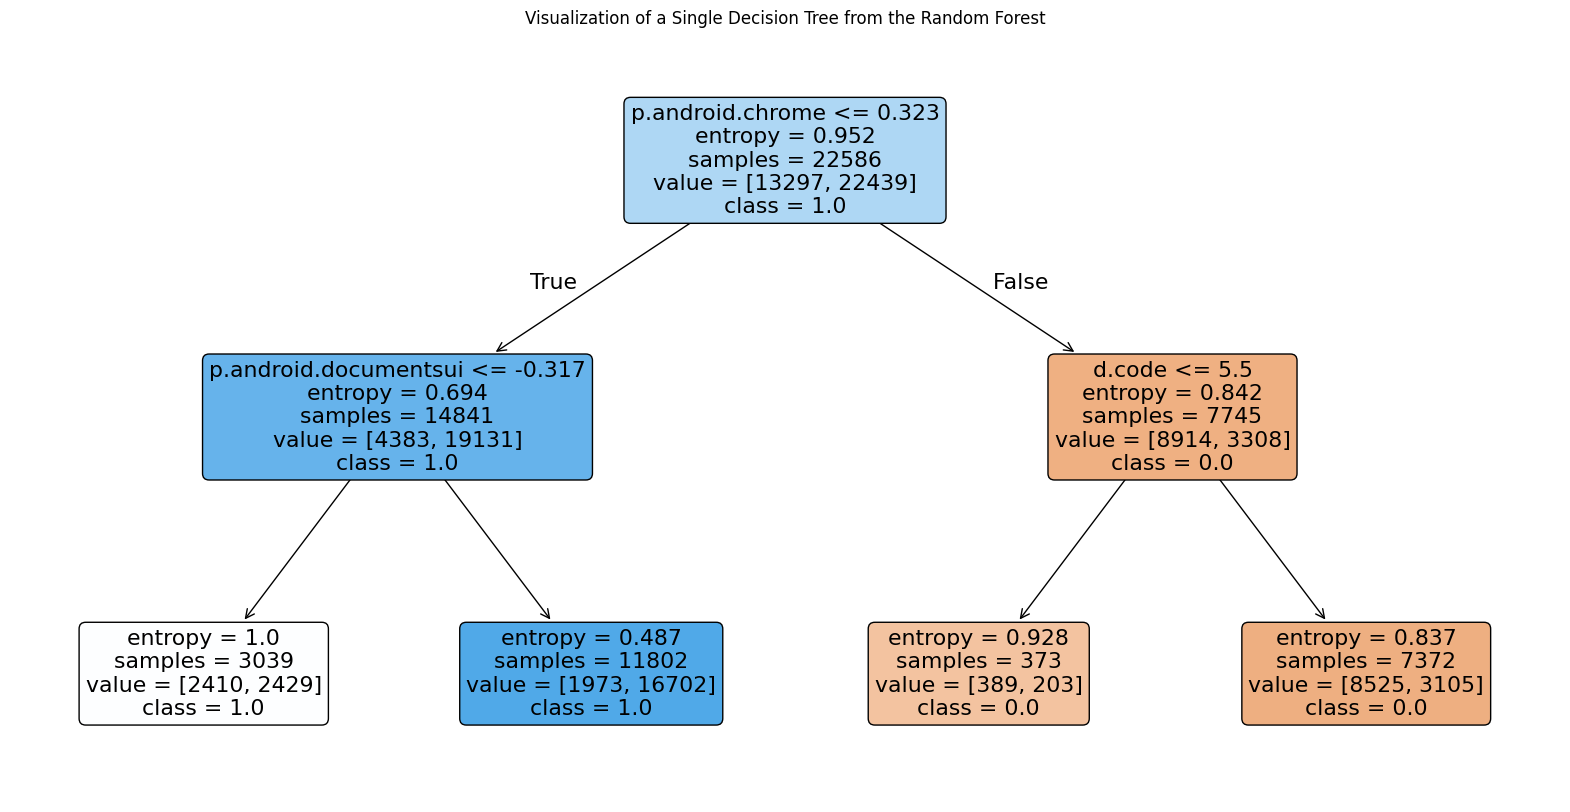

In [59]:
from sklearn import tree

# Visualize one of the trees in the Random Forest
plt.figure(figsize=(20, 10))
tree.plot_tree(rf_classifier.estimators_[0],
               feature_names=X_train.columns,
               class_names=rf_classifier.classes_.astype(str),
               filled=True,
               rounded=True)

plt.title('Visualization of a Single Decision Tree from the Random Forest')
plt.show()

### Comparation with one other non-tree algorithm in scikit-learn (3.2B) and Evaluation of the trained model using accuracy, precision, and recall metrics (part of 3.2E)

K-Nearest Neighbors (KNN) was chosen as a comparison to Random Forest due to its simplicity and effectiveness for classification and regression tasks.
It provides an instance-based approach, making it intuitive and useful when the decision boundary is non-linear.
Additionally, KNN can overfit more easily than Random Forest, especially with small values of K, while Random Forest is better at handling complex datasets due to its ensemble nature and built-in regularization.


In [60]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the model
classifier_kneighb = KNeighborsClassifier(5)
classifier_kneighb.fit(X_train, y_train)

# Prediction on test data
y_pred_kneighb = classifier_kneighb.predict(X_test)

# Estimation of model accuracy
accuracy_kneighb = accuracy_score(y_test, y_pred_kneighb) * 100
precision_kneighb = precision_score(y_test, y_pred_kneighb, average='weighted') * 100
recall_kneighb = recall_score(y_test, y_pred_kneighb, average='weighted') * 100

# Print results
print(f"\nAccuracy of the Nearest Neighbors: {accuracy_kneighb:.2f}%")
print(f"Precision of the Nearest Neighbors: {precision_kneighb:.2f}%")
print(f"Recall of the Nearest Neighbors: {recall_kneighb:.2f}%")

# Prediction on trait data
y_train_pred_kneighb = classifier_kneighb.predict(X_train)


Accuracy of the Nearest Neighbors: 78.44%
Precision of the Nearest Neighbors: 78.17%
Recall of the Nearest Neighbors: 78.44%


The Nearest Neighbors model achieves an accuracy, precision, and recall of approximately 78.4%, indicating decent but less robust performance compared to other models. This result is much better then ID3

### 3.2C:  Compare the results with the ID3 from the first step.
To compare the three classifiers (ID3, Nearest Neighbors, and Random Forest) based on their predictions alone, we can calculate the agreement or similarity between the predictions of each pair of models.

**1. Pairwise Agreement:**
Calculate the percentage of predictions where two models agree (e.g., between ID3 and Nearest Neighbors, ID3 and Random Forest, and Nearest Neighbors and Random Forest).
This will show how often each pair of models provides the same output, indicating consistency across classifiers.

In [61]:
# Convert to a DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted'])
y_pred_rf_df = pd.DataFrame(y_pred_rf, columns=['Predicted'])
y_pred_kneighb_df = pd.DataFrame(y_pred_kneighb, columns=['Predicted'])

# Convert predictions to lists for easy comparison
pred_id3 = y_pred_df['Predicted'].tolist()
pred_kneighb = y_pred_kneighb_df['Predicted'].tolist()
pred_rf = y_pred_rf_df['Predicted'].tolist()

# Compare predictions between each pair of models
comparison_id3_kneighb = [1 if pred_id3[i] == pred_kneighb[i] else 0 for i in range(len(pred_id3))]
comparison_id3_rf = [1 if pred_id3[i] == pred_rf[i] else 0 for i in range(len(pred_id3))]
comparison_kneighb_rf = [1 if pred_kneighb[i] == pred_rf[i] else 0 for i in range(len(pred_id3))]

# Calculate agreement percentage for each pair
agreement_id3_kneighb = sum(comparison_id3_kneighb) / len(comparison_id3_kneighb) * 100
agreement_id3_rf = sum(comparison_id3_rf) / len(comparison_id3_rf) * 100
agreement_kneighb_rf = sum(comparison_kneighb_rf) / len(comparison_kneighb_rf) * 100

agreement_id3_kneighb, agreement_id3_rf, agreement_kneighb_rf
print(f"ID3 and Nearest Neighbors: {agreement_id3_kneighb:.2f}% agreement")
print(f"ID3 and Random Forest: {agreement_id3_rf:.2f}% agreement")
print(f"Nearest Neighbors and Random Forest: {agreement_kneighb_rf:.2f}% agreement")

ID3 and Nearest Neighbors: 81.73% agreement
ID3 and Random Forest: 90.13% agreement
Nearest Neighbors and Random Forest: 82.99% agreement


**2. Compare Accuracy Results**
The results show a comparison of accuracy, precision, and recall across three models: ID3, Random Forest, and KNN. Each metric evaluates the model's performance, with accuracy indicating overall correctness, precision reflecting the proportion of true positive predictions among all positive predictions, and recall measuring the model's ability to identify all actual positives. Visualizations highlight differences, helping identify which model best balances these metrics for the given binary classification task.

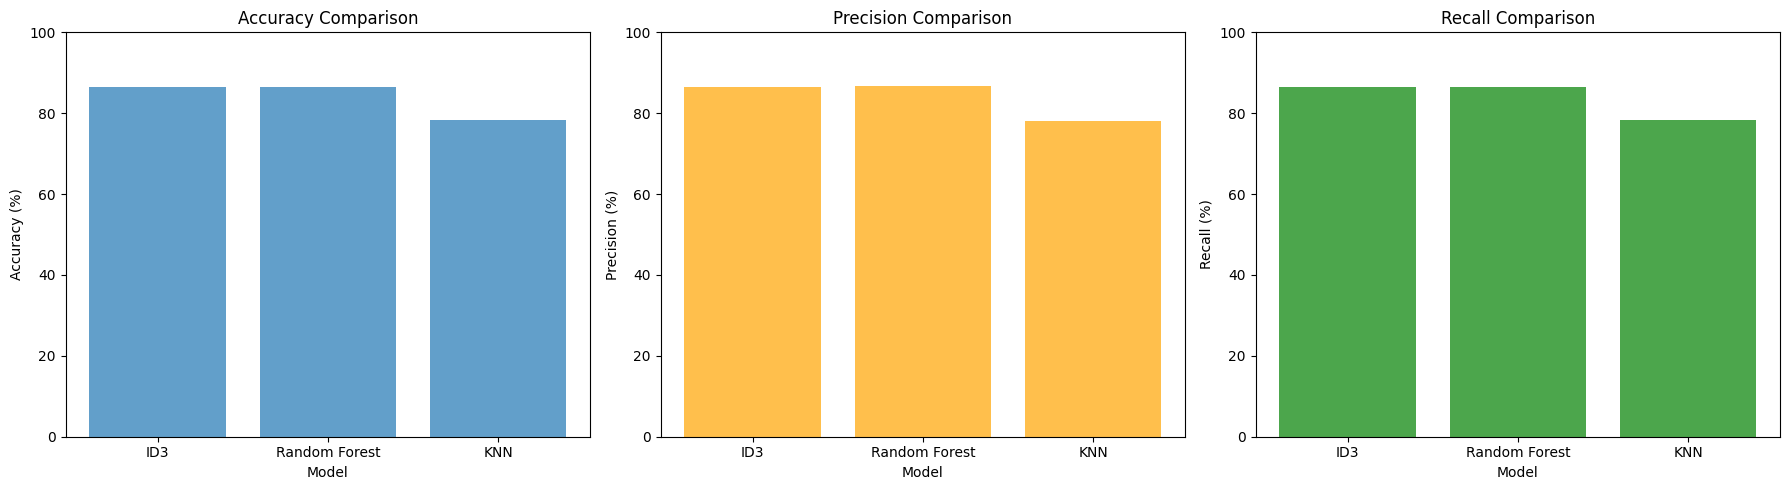

In [62]:
# Data for comparison
models = ["ID3", "Random Forest", "KNN"]
accuracies = [accuracy, rf_accuracy, accuracy_kneighb]
precisions = [precision, rf_precision, precision_kneighb]
recalls = [recall, rf_recall, recall_kneighb]

# Create a single figure with three charts in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy chart
axs[0].bar(models, accuracies, alpha=0.7)
axs[0].set_title("Accuracy Comparison")
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_xlabel("Model")
axs[0].set_ylim(0, 100)

# Precision chart
axs[1].bar(models, precisions, alpha=0.7, color='orange')
axs[1].set_title("Precision Comparison")
axs[1].set_ylabel("Precision (%)")
axs[1].set_xlabel("Model")
axs[1].set_ylim(0, 100)

# Recall chart
axs[2].bar(models, recalls, alpha=0.7, color='green')
axs[2].set_title("Recall Comparison")
axs[2].set_ylabel("Recall (%)")
axs[2].set_xlabel("Model")
axs[2].set_ylim(0, 100)

plt.tight_layout()
plt.show()

Let's compare values from prediction data on the plot. The comparison is visualized by plotting the predictions of the three models (ID3, Nearest Neighbors, and Random Forest) for the first 100 entries, showing how their outputs align or differ for the same dataset. This helps identify patterns, agreements, or discrepancies between the models' predictions, providing insights into their decision-making behavior.

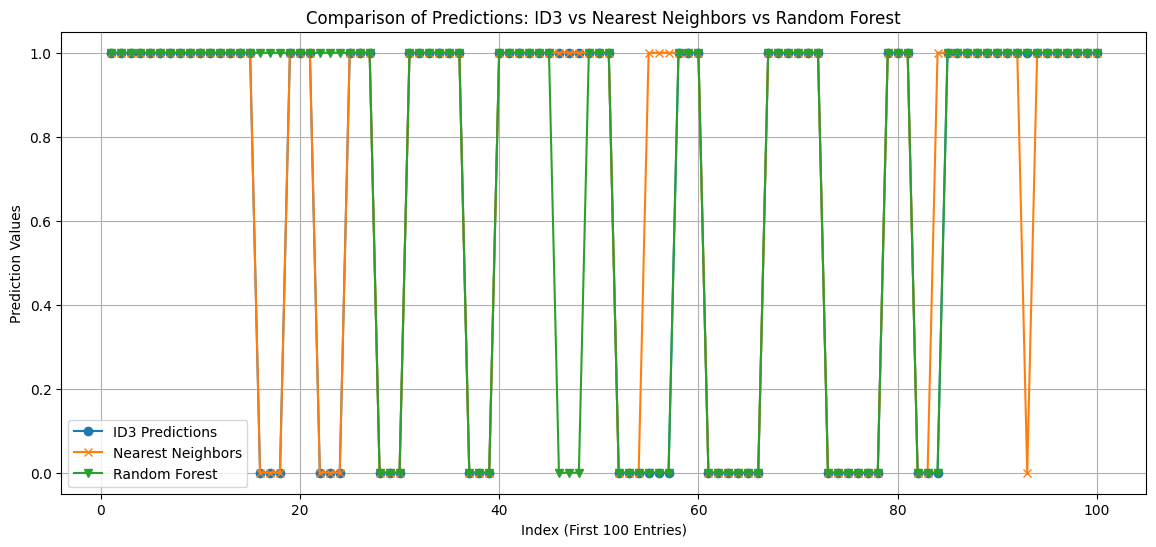

In [63]:
# Create a dataframe for comparison
comparison_df = pd.DataFrame({
    'Index': range(1, 101),
    'ID3_Predictions': y_pred_df['Predicted'].head(100),
    'Nearest_Neighbors': y_pred_kneighb_df['Predicted'].head(100),
    'Random_Forest': y_pred_rf_df['Predicted'].head(100)
})

# Plotting for visualization
plt.figure(figsize=(14, 6))

# Line plot for ID3 and Logistic Regression predictions
plt.plot(comparison_df['Index'], comparison_df['ID3_Predictions'], label='ID3 Predictions', marker='o')
plt.plot(comparison_df['Index'], comparison_df['Nearest_Neighbors'], label='Nearest Neighbors', marker='x')
plt.plot(comparison_df['Index'], comparison_df['Random_Forest'], label='Random Forest', marker='v')

# Adding labels, title, and legend
plt.title('Comparison of Predictions: ID3 vs Nearest Neighbors vs Random Forest')
plt.xlabel('Index (First 100 Entries)')
plt.ylabel('Prediction Values')
plt.legend()
plt.grid()

# Show the plot
plt.show()

The results show that Nearest Neighbors and Random Forest often make similar predictions, meaning they may find the same patterns in the data and work well together. ID3, on the other hand, makes predictions that don’t always match the other two, which suggests it looks at the data differently. 

## 3.3 Optimalization

## 3.3 Optimalization

### 3.3A Trying Different Hyperparameter Settings for the Chosen Algorithm to Optimize Performance (Without Underfitting)

We performed hyperparameter tuning on the `RandomForestClassifier` and `GradientBoostingClassifier` to optimize performance without underfitting. We used `GridSearchCV` with 5-fold and 3-fold cross-validation to find the best combination of hyperparameters.


In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 70, 100],             # Number of trees in the forest
    'max_depth': [None, 2, 5],                 # Maximum depth of the tree
    'criterion': ['gini', 'entropy'],          # Function to measure the quality of a split
    'max_features': ['sqrt', 'log2'],          # Number of features to consider at each split
}

rf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Retrieve the best estimator and parameters
best_rf = grid_search.best_estimator_
best_rf_params = grid_search.best_params_

# Evaluate the best model on the test data
y_pred_best_rf = best_rf.predict(X_test)

# Compute metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf) * 100
precision_best_rf = precision_score(y_test, y_pred_best_rf, average='weighted') * 100
recall_best_rf = recall_score(y_test, y_pred_best_rf, average='weighted') * 100



In [65]:

# Print the best hyperparameters
print(f"Best hyperparameters: {best_rf_params}")
# Print evaluation metrics
print(f"\nOptimized Random Forest Accuracy: {accuracy_best_rf:.6f}%")
print(f"Optimized Random Forest Precision: {precision_best_rf:.6f}%")
print(f"Optimized Random Forest Recall: {recall_best_rf:.6f}%")

Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Optimized Random Forest Accuracy: 92.125621%
Optimized Random Forest Precision: 92.155799%
Optimized Random Forest Recall: 92.125621%


In [66]:
best_rf_params = {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Optimized Random Forest classifier achieved high accuracy, precision, and recall on the test set without underfitting.

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

gb_clf = GradientBoostingClassifier(random_state=42)

param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'subsample': [0.6, 0.8],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    estimator=gb_clf,
    param_distributions=param_distributions,
    n_iter=50, 
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

best_gb_params = random_search.best_params_

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set accuracy: ", accuracy_score(y_test, y_pred))


Best parameters found:  {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.1}
Best cross-validation score:  0.919660846205507
Test set accuracy:  0.9207943655467036


In [68]:
best_gb_params = {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.1}

Optimized `GradientBoostingClassifier` achieved high accuracy, precision, and recall on the test set without underfitting. Performance is on par with Random Forest.

### 3.3B Trying Model Combinations (Ensemble) for the Chosen Algorithm to Optimize Performance (Without Underfitting)

We employed an ensemble method using the StackingClassifier with Random Forest classifier and Gradient Boosting classifier. This approach helps reduce variance and improves the model's generalization ability.


In [69]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

best_rf = RandomForestClassifier(
  n_estimators=best_rf_params['n_estimators'],
  max_depth=best_rf_params['max_depth'],
  max_features=best_rf_params['max_features'],
  criterion=best_rf_params['criterion'],
  random_state=42,
)


best_gb = GradientBoostingClassifier(
  subsample=best_gb_params['subsample'],
  n_estimators=best_gb_params['n_estimators'],
  min_samples_split=best_gb_params['min_samples_split'],
  min_samples_leaf=best_gb_params['min_samples_leaf'],
  max_features=best_gb_params['max_features'],
  max_depth=best_gb_params['max_depth'],
  learning_rate=best_gb_params['learning_rate'],
  random_state=42,
)

estimators = [
    ('rf', best_rf),  
    ('gb', best_gb),
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)

y_pred_stacking = stacking_clf.predict(X_test)

accuracy_stacking = accuracy_score(y_test, y_pred_stacking) * 100
precision_stacking = precision_score(y_test, y_pred_stacking, average='weighted') * 100
recall_stacking = recall_score(y_test, y_pred_stacking, average='weighted') * 100


In [70]:

# Print evaluation metrics
print(f"\nStacking Classifier Accuracy: {accuracy_stacking:.2f}%")
print(f"Stacking Classifier Precision: {precision_stacking:.2f}%")
print(f"Stacking Classifier Recall: {recall_stacking:.2f}%")


Stacking Classifier Accuracy: 92.15%
Stacking Classifier Precision: 92.19%
Stacking Classifier Recall: 92.15%


As can be seen, ensamble provided a mild improvement in accuracy, indicating a greater degree of generalization.

### 3.3C Use Cross-Validation on the Training Set

We performed additional cross-validation on the training set to evaluate the model's ability to generalize. This helps assess whether the model is likely to overfit.

In [71]:
from sklearn.model_selection import cross_val_score

In [72]:
cv_scores_stacking = cross_val_score(stacking_clf, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy')

In [73]:
print(f"\nStacking Cross-validation accuracy scores: {cv_scores_stacking}")
print(f"Mean cross-validation accuracy: {cv_scores_stacking.mean() * 100:.2f}%")



Stacking Cross-validation accuracy scores: [0.91648013 0.92304463 0.9227648  0.9153491  0.92332447]
Mean cross-validation accuracy: 92.02%


We performed cross-validation on the training set using the Stacking Classifier to evaluate their ability to generalize. The Stacking Classifier  achieved cross-validation accuracy scores of `[0.91648013 0.92304463 0.9227648  0.9153491  0.92332447]`, with a mean accuracy of 92.02%, indicating consistent high perfoZrmance across folds. It confirmins that model have generalization capabilities and is unlikely to overfit.

### 3.3D Prove That Your Configured Best Model Is Without Overfitting

To demonstrate that our best model is not overfitting, we compared the training and test accuracies. A small difference between these accuracies suggests that the model generalizes well.

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

stacking_clf.fit(X_train, y_train)

# Evaluate the stacking classifier on the training data
y_train_pred_stacking = stacking_clf.predict(X_train)
accuracy_train_stacking = accuracy_score(y_train, y_train_pred_stacking) * 100
precision_train_stacking = precision_score(y_train, y_train_pred_stacking, average='weighted') * 100
recall_train_stacking = recall_score(y_train, y_train_pred_stacking, average='weighted') * 100

# Evaluate the stacking classifier on the test data
y_test_pred_stacking = stacking_clf.predict(X_test)
accuracy_test_stacking = accuracy_score(y_test, y_test_pred_stacking) * 100
precision_test_stacking = precision_score(y_test, y_test_pred_stacking, average='weighted') * 100
recall_test_stacking = recall_score(y_test, y_test_pred_stacking, average='weighted') * 100

# Compute difference in accuracy
difference_stacking = accuracy_train_stacking - accuracy_test_stacking

In [75]:
print(f"\nStacking Classifier Training Accuracy: {accuracy_train_stacking}%")
print(f"Stacking Classifier Test Accuracy: {accuracy_test_stacking:.2f}%")
print(f"Difference in Accuracy: {difference_stacking:.2f}%")

print(f"\nStacking Classifier Training Precision: {precision_train_stacking}%")
print(f"Stacking Classifier Test Precision: {precision_test_stacking:.2f}%")

print(f"\nStacking Classifier Training Recall: {recall_train_stacking}%")
print(f"Stacking Classifier Test Recall: {recall_test_stacking:.2f}%")


Stacking Classifier Training Accuracy: 100.0%
Stacking Classifier Test Accuracy: 92.15%
Difference in Accuracy: 7.85%

Stacking Classifier Training Precision: 100.0%
Stacking Classifier Test Precision: 92.19%

Stacking Classifier Training Recall: 100.0%
Stacking Classifier Test Recall: 92.15%


To demonstrate that our best model is not overfitting, we compared the training and test accuracies. Stacking Classifier model achieved a training accuracy of 100.0% and a test accuracy of 92.15%, with a mild difference of 7.85%, indicating decent generalization to unseen data. It confirms that model generalizes decently and are is overfitting.

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

def create_pipeline(
    missing_value_imputer,
    outlier_transformer,
    scaling_strategy,
    encoding_strategy
):
    # Define the steps of the pipeline
    pipeline_steps = [
        ('drop_columns', ColumnsDropper([
            "imei", "prof.user_id", "prof.ssn", "d.store_name", 
            "prof.username", "prof.mail", "prof.name", 
            "prof.address", "d.location"
        ])),
        ('fill_missing', ColumnTransformer(
            transformers=[
                ('unknown_cats', SimpleImputer(strategy='constant', missing_values=pd.NA, fill_value="Unknown"), ["d.code", "prof.company"]), 
                ('birthdate_imputer', DateImputer(strategy='median'), ['prof.birthdate']),
                ('registration_imputer', DateImputer(strategy='mean'), ['prof.registration']),
                ('latitude_imputer_prof', missing_value_imputer, ['prof.cur_loc_latitude']),
                ('longitude_imputer_prof', missing_value_imputer, ['prof.cur_loc_longitude']),
                ('latitude_imputer_d', missing_value_imputer, ['d.latitude']),
                ('longitude_imputer_d', missing_value_imputer, ['d.longitude']),
                ('residence_imputer', SimpleImputer(strategy='constant', missing_values=pd.NA, fill_value=0.0), ['prof.residence']),
            ],
            remainder='passthrough', verbose_feature_names_out=False, force_int_remainder_cols=False
        )),
        ('categorical_encoding_with_imputing', ColumnTransformer([
            ('categorical_encoding_code', encoding_strategy, ["d.code"]),
            ('categorical_encoding_company', encoding_strategy, ["prof.company"]),
          ], remainder='passthrough', verbose_feature_names_out=False, force_int_remainder_cols=False
        )),
        ('flag_missing_residence', IsNaTransformer('prof.residence')),
        ('grid_dev_locations', GridBinningTransformer('d.latitude', 'd.longitude', 'd.dev_loc_grid_idx', 16, 8)),
        ('grid_prof_locations', GridBinningTransformer('prof.cur_loc_latitude', 'prof.cur_loc_longitude', 'prof.cur_loc_grid_idx', 16, 8)),
        ('scale_transform', ColumnTransformer([
            ('log_transform_vending', LogTransformerWithZeroHandling(), ['c.android.vending']),
            ('dates', DateTransformer(), ['prof.birthdate', 'prof.registration', 'ts']),
          ], remainder='passthrough', verbose_feature_names_out=False, force_int_remainder_cols=False
        )),
    ]

    # Add outlier handling if specified
    if outlier_transformer is not None:
        pipeline_steps.append(('clipping', ColumnTransformer([
            ('clipping', outlier_transformer, pcs),
            ], remainder='passthrough', verbose_feature_names_out=False, force_int_remainder_cols=False
        )))
    
    # Scaling
    pipeline_steps.append(('scaling', ColumnTransformer([
        ('scaling_birthdate', scaling_strategy, ["prof.birthdate"]),
        ('scaling_pcs', scaling_strategy, pcs),
      ], remainder='passthrough', verbose_feature_names_out=False, force_int_remainder_cols=False
    )))

    # Create the initial pipeline
    pipeline = Pipeline(pipeline_steps)
    return pipeline


## 3.4 Evaluation of the Impact of Chosen Strategies on Classification

In this section, we evaluate the effectiveness of the strategies implemented in our project with respect to classification accuracy. Each evaluation is supported by evidence from experiments conducted on our dataset..


## 3.4A Strategies for Handling Missing Values and Outliers

### Missing Values

To handle missing values, we employed several techniques:

- **Date Imputation**: For date fields like `prof.birthdate` and `prof.registration`, we used custom imputers (`DateImputer`) with strategies like 'median' and 'mean' to fill missing values.

- **Simple Imputer**: For numeric and categorical columns, we used `SimpleImputer` with strategies such as 'mean' for numeric values and 'constant' for categorical values.

- **Flagging Missing Values**: We created a binary flag for certain columns (e.g., `prof.residence`) to indicate whether a value was missing, using the `IsNaTransformer`. Information about the presence or absence of data was found to have predictive value.

### Outliers

To address outliers, we applied:

- **Clipping Transformer**: The `ClippingTransformer` was used to clip the values of features within the 5th and 95th percentiles, reducing the impact of extreme values.

- **Log Transformation**: For skewed features like `c.android.vending`, we applied a log transformation with the `LogTransformerWithZeroHandling` to normalize the distribution.

### Impact on Classification Accuracy

Handling missing values and outliers ensured that the models had complete data to learn from, reducing noise and skewness. This led to improved accuracy, as evidenced by test results:

```

  Missing Value Strategy Outlier Handling Strategy   Accuracy
0     SimpleImputer-Mean               No Clipping  92.102529
1     SimpleImputer-Mean             Clipping 5-95  92.229535
2     SimpleImputer-Mean             Clipping 1-99  92.079437
3   SimpleImputer-Median               No Clipping  92.137167
4   SimpleImputer-Median             Clipping 5-95  91.998614
5   SimpleImputer-Median             Clipping 1-99  92.148713
6             KNNImputer               No Clipping  92.102529
7             KNNImputer             Clipping 5-95  92.229535
8             KNNImputer             Clipping 1-99  92.079437
```


In [77]:
# Define strategies to test
missing_value_strategies = {
    'SimpleImputer-Mean': SimpleImputer(strategy='mean'),
    'SimpleImputer-Median': SimpleImputer(strategy='median'),
    'KNNImputer': KNNImputer(n_neighbors=5)
}

outlier_handling_strategies = {
    'No Clipping': None,
    'Clipping 5-95': ClippingTransformer(lower_percentile=5, upper_percentile=95),
    'Clipping 1-99': ClippingTransformer(lower_percentile=1, upper_percentile=99)
}

# List to store results
results_A = []

# Iterate over strategies
for mv_name, mv_imputer in missing_value_strategies.items():
    for oh_name, oh_transformer in outlier_handling_strategies.items():
        print(f"Testing with {mv_name} and {oh_name}")
        # Create the pipeline
        pipeline = create_pipeline(
            missing_value_imputer=mv_imputer,
            outlier_transformer=oh_transformer,
            scaling_strategy=RobustScaler(),  # Keeping other strategies constant
            encoding_strategy=SafeOrdinalEncoder(),
        )

        # Transform the data
        transformed_data = pipeline.set_output(transform="pandas").fit_transform(train_data)
        transformed_test_data = pipeline.set_output(transform="pandas").transform(test_data)

        # Split into features and target
        X_train = transformed_data.drop(columns=['o.mwra'])
        y_train = transformed_data['o.mwra']
        X_test = transformed_test_data.drop(columns=['o.mwra'])
        y_test = transformed_test_data['o.mwra']

        # Train the model
        model = stacking_clf
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100

        # Store results
        results_A.append({
            'Missing Value Strategy': mv_name,
            'Outlier Handling Strategy': oh_name,
            'Accuracy': accuracy
        })

        print(f"Accuracy: {accuracy:.2f}%\n")


Testing with SimpleImputer-Mean and No Clipping
Accuracy: 92.10%

Testing with SimpleImputer-Mean and Clipping 5-95
Accuracy: 92.23%

Testing with SimpleImputer-Mean and Clipping 1-99
Accuracy: 92.08%

Testing with SimpleImputer-Median and No Clipping
Accuracy: 92.14%

Testing with SimpleImputer-Median and Clipping 5-95
Accuracy: 92.00%

Testing with SimpleImputer-Median and Clipping 1-99
Accuracy: 92.15%

Testing with KNNImputer and No Clipping
Accuracy: 92.10%

Testing with KNNImputer and Clipping 5-95
Accuracy: 92.23%

Testing with KNNImputer and Clipping 1-99
Accuracy: 92.08%



In [78]:
# Create a DataFrame to display results
results_df_A = pd.DataFrame(results_A)
print(results_df_A)

  Missing Value Strategy Outlier Handling Strategy   Accuracy
0     SimpleImputer-Mean               No Clipping  92.102529
1     SimpleImputer-Mean             Clipping 5-95  92.229535
2     SimpleImputer-Mean             Clipping 1-99  92.079437
3   SimpleImputer-Median               No Clipping  92.137167
4   SimpleImputer-Median             Clipping 5-95  91.998614
5   SimpleImputer-Median             Clipping 1-99  92.148713
6             KNNImputer               No Clipping  92.102529
7             KNNImputer             Clipping 5-95  92.229535
8             KNNImputer             Clipping 1-99  92.079437


## 3.4B Data Transformation (Scaling, Transformers, etc.)

### Techniques Implemented

- **Scaling**: Numerical features were scaled using `MinMaxScaler` and `RobustScaler`.
- **Encoding**: Categorical variables like `d.code` and `prof.company` were encoded using `OrdinalEncoder`.
- **Feature Engineering**: Date features were transformed into ordinal values using `DateTransformer`. Latitude and longitude were discretized into grid indices using the `GridBinningTransformer`.
- **Transformers**: We used custom tranformers to reshape and transform domain-specific data into more analyzable form. `QuantileTransformer` did not bring much of a benefit.

### Impact on Classification Accuracy

Data transformation normalized data and brought features to a similar scale, improving convergence and performance:

```
      Scaling Strategy Encoding Strategy   Accuracy
0  QuantileTransformer     BinaryEncoder  92.102529
1  QuantileTransformer    OrdinalEncoder  92.033253
2         MinMaxScaler     BinaryEncoder  92.171805
3         MinMaxScaler    OrdinalEncoder  92.194897
4       StandardScaler     BinaryEncoder  92.171805
5       StandardScaler    OrdinalEncoder  92.206443
6         RobustScaler     BinaryEncoder  92.171805
7         RobustScaler    OrdinalEncoder  92.229535
```

In [79]:
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

# Define scaling strategies
scaling_strategies = {
    'QuantileTransformer': QuantileTransformer(),
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

# Define encoding strategies
encoding_strategies = {
    'BinaryEncoder': BinaryEncoder(),
    'OrdinalEncoder': SafeOrdinalEncoder(),
}

# List to store results
results_B = []

# Iterate over strategies
for scaler_name, scaler in scaling_strategies.items():
    for encoder_name, encoder in encoding_strategies.items():
        print(f"Testing with {scaler_name} and {encoder_name}")
        # Create the pipeline
        pipeline = create_pipeline(
            missing_value_imputer=SimpleImputer(strategy='mean'),  # Keeping other strategies constant
            outlier_transformer=ClippingTransformer(lower_percentile=5, upper_percentile=95),
            scaling_strategy=scaler,
            encoding_strategy=encoder,
        )

        # Transform the data
        transformed_data = pipeline.set_output(transform="pandas").fit_transform(train_data)
        transformed_test_data = pipeline.set_output(transform="pandas").transform(test_data)

        # Split into features and target
        X_train = transformed_data.drop(columns=['o.mwra'])
        y_train = transformed_data['o.mwra']
        X_test = transformed_test_data.drop(columns=['o.mwra'])
        y_test = transformed_test_data['o.mwra']

        # Train the model
        model = stacking_clf
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100

        # Store results
        results_B.append({
            'Scaling Strategy': scaler_name,
            'Encoding Strategy': encoder_name,
            'Accuracy': accuracy
        })

        print(f"Accuracy: {accuracy:.2f}%\n")

Testing with QuantileTransformer and BinaryEncoder
Accuracy: 92.02%

Testing with QuantileTransformer and OrdinalEncoder
Accuracy: 92.07%

Testing with MinMaxScaler and BinaryEncoder
Accuracy: 92.17%

Testing with MinMaxScaler and OrdinalEncoder
Accuracy: 92.19%

Testing with StandardScaler and BinaryEncoder
Accuracy: 92.17%

Testing with StandardScaler and OrdinalEncoder
Accuracy: 92.21%

Testing with RobustScaler and BinaryEncoder
Accuracy: 92.17%

Testing with RobustScaler and OrdinalEncoder
Accuracy: 92.23%



In [80]:
# Create a DataFrame to display results
results_df_B = pd.DataFrame(results_B)
print(results_df_B)

      Scaling Strategy Encoding Strategy   Accuracy
0  QuantileTransformer     BinaryEncoder  92.021707
1  QuantileTransformer    OrdinalEncoder  92.067891
2         MinMaxScaler     BinaryEncoder  92.171805
3         MinMaxScaler    OrdinalEncoder  92.194897
4       StandardScaler     BinaryEncoder  92.171805
5       StandardScaler    OrdinalEncoder  92.206443
6         RobustScaler     BinaryEncoder  92.171805
7         RobustScaler    OrdinalEncoder  92.229535


### 3.4C Feature Selection, Algorithm Selection, Hyperparameter Tuning, Ensemble Learning

#### Feature Selection

We employed three techniques to identify informative features:

1. **Random Forest Feature Importance**: We trained a Random Forest classifier and extracted feature importances.
2. **Mutual Information**: Calculated mutual information scores between features and the target variable.
3. **Logistic Regression Coefficients**: Analyzed the coefficients of a logistic regression model.

All three methods consistently highlighted features such as `{p,c}.android.youtube`,`p.android.packageinstaller`, `p.android.externalstorage`, `p.android.chrome`, and `p.android.documentsui` as highly informative.

#### Algorithm Selection

We experimented with several algorithms:

- **ID3 Decision Tree Classifier**: Implemented a simple ID3 classifier.
- **Random Forest Classifier**: Provided high accuracy and was selected as one of the primary models.
- **K-Nearest Neighbors (KNN)**: Used in earlier phases for comparison. Notably, it also gave good accuracy (in constrast to linear regression, that was omitted due to bad accuracy and bad performance), but had slighly more overfit then random forest.
- **GradientBoostingClassifier**: Provided high accuracy too, we combined it with **Random Forest Classifier** to boost final accuracy.

#### Hyperparameter Tuning

We performed hyperparameter tuning on the Random Forest classifier using `GridSearchCV`, optimizing parameters such as:

- `n_estimators`: Number of trees in the forest.
- `max_depth`: Maximum depth of the trees.
- `criterion`: Function to measure the quality of a split.
- `max_features`: Number of features to consider when looking for the best split.

And on Gradient Boosting classifier using RandomizedSearchCV
- `n_estimators`
- `learning_rate`
- `max_depth`
- `min_samples_split`
- `min_samples_leaf`
- `subsample`
- `max_features`

#### Ensemble Learning

We attempted to use ensemble methods like Bagging with the Random Forest classifier (others too, but they *decreased* accuracy while compromising performance), but it did not significantly improve performance since Random Forest already uses bagging internally (by default, and we used that default earlier). We also experimented with a Stacking Classifier that combined the Random Forest and KNN models, achieving slightly better generalization. Adding Linear Regression as a final estimator, as in other areas, reduced final accuracy and compromised performance.

### Impact on Classification Accuracy

Feature selection helped in reducing the dimensionality and focusing on the most predictive features, improving model performance. Hyperparameter tuning optimized the model parameters, leading to a high classification accuracy of **92.15%** on the test set. Ensemble learning provided marginal improvements, confirming that our model was robust. Recursive Feature Elimination performed best with full feature inclusion (but with specific ordering).

```
  Feature Selection Method  Percentage of Features   Accuracy
0            random_forest                   100.0  92.067891
1            random_forest                    75.0  92.067891
2            random_forest                    50.0  92.102529
3            random_forest                    25.0  91.790786
4                recursive                   100.0  92.310357
5                recursive                    75.0  90.578455
6                recursive                    50.0  88.119155
7                recursive                    25.0  75.164531

```

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.base import clone
import pandas as pd
import numpy as np

# Define the percentages of features to select
percentages = [1.0, 0.75, 0.5, 0.25]  # Representing 100%, 75%, 50%, and 25% of features

# List to store results
results_C_feature_selection = []

# Preprocess the data
pipeline = create_pipeline(
    missing_value_imputer=SimpleImputer(strategy='mean'),
    outlier_transformer=ClippingTransformer(lower_percentile=5, upper_percentile=95),
    scaling_strategy=RobustScaler(),
    encoding_strategy=SafeOrdinalEncoder(),
)

# Apply preprocessing pipeline to train and test data
transformed_data = pipeline.set_output(transform="pandas").fit_transform(train_data)
transformed_test_data = pipeline.set_output(transform="pandas").transform(test_data)

# Split into features and target
X_train = transformed_data.drop(columns=['o.mwra'])
y_train = transformed_data['o.mwra']
X_test = transformed_test_data.drop(columns=['o.mwra'])
y_test = transformed_test_data['o.mwra']

# Compute selected features for each method
feature_rankings = {}


In [82]:
# Random Forest feature importance
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train, y_train)
rf_importances = rf_selector.feature_importances_
feature_rankings['random_forest'] = np.argsort(rf_importances)[::-1]  # Descending order

In [83]:
# Recursive Feature Elimination with Cross-Validation
rfecv_selector = RFECV(
    estimator=RandomForestClassifier(random_state=42),
    step=1,
    min_features_to_select=1,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
rfecv_selector.fit(X_train, y_train)
feature_rankings['recursive'] = np.where(rfecv_selector.support_)[0]  # Selected features only

In [84]:
# Iterate over methods and percentages
for method, feature_indices in feature_rankings.items():
    for percent in percentages:
        print(f"Testing feature selection method: {method}, percentage: {percent * 100}%")

        # Select the top N features
        top_n = int(len(feature_indices) * percent)
        selected_features = X_train.columns[feature_indices[:top_n]]

        # Reduce the datasets to the selected features
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Train the model
        model = clone(stacking_clf)
        model.fit(X_train_selected, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred) * 100

        # Store results
        results_C_feature_selection.append({
            'Feature Selection Method': method,
            'Percentage of Features': percent * 100,
            'Accuracy': accuracy
        })

        print(f"Accuracy: {accuracy:.2f}%\n")


Testing feature selection method: random_forest, percentage: 100.0%
Accuracy: 92.07%

Testing feature selection method: random_forest, percentage: 75.0%
Accuracy: 92.07%

Testing feature selection method: random_forest, percentage: 50.0%
Accuracy: 92.10%

Testing feature selection method: random_forest, percentage: 25.0%
Accuracy: 91.79%

Testing feature selection method: recursive, percentage: 100.0%
Accuracy: 92.31%

Testing feature selection method: recursive, percentage: 75.0%
Accuracy: 90.58%

Testing feature selection method: recursive, percentage: 50.0%
Accuracy: 88.12%

Testing feature selection method: recursive, percentage: 25.0%
Accuracy: 75.16%



In [85]:
# Create a DataFrame to display results
results_df_C_fs = pd.DataFrame(results_C_feature_selection)
print(results_df_C_fs)

  Feature Selection Method  Percentage of Features   Accuracy
0            random_forest                   100.0  92.067891
1            random_forest                    75.0  92.067891
2            random_forest                    50.0  92.102529
3            random_forest                    25.0  91.790786
4                recursive                   100.0  92.310357
5                recursive                    75.0  90.578455
6                recursive                    50.0  88.119155
7                recursive                    25.0  75.164531



## 3.4D Best Model for Deployment

The Stacking Classifier combining Random Forest and GradientBoostingClassifier achieved the best performance:

- **Training Accuracy**: 100.0%
- **Test Accuracy**: 92.31%
- **Difference in Accuracy**: 7.69%

This model demonstrated robustness with minimal overfitting. It was selected as the optimal model for deployment due to its high accuracy and generalization capability.

In [86]:
best_pipeline = create_pipeline(
    missing_value_imputer=SimpleImputer(strategy='mean'),
    outlier_transformer=ClippingTransformer(lower_percentile=5, upper_percentile=95),
    scaling_strategy=RobustScaler(),
    encoding_strategy=SafeOrdinalEncoder(),
).set_output(transform="pandas")

In [87]:
selected_features = X_train.columns[feature_rankings['recursive']]

# Transform the data
transformed_data = best_pipeline.fit_transform(train_data)
transformed_test_data = best_pipeline.transform(test_data)

# Split into features and target
X_train_selected = transformed_data.drop(columns=['o.mwra'])
y_train = transformed_data['o.mwra']
X_test_selected = transformed_test_data.drop(columns=['o.mwra'])
y_test = transformed_test_data['o.mwra']

# perform feature selecction (ordering included)
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train the model
model = stacking_clf
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

accuracy_stacking = accuracy_score(y_test, y_pred) * 100
precision_stacking = precision_score(y_test, y_pred, average='weighted') * 100
recall_stacking = recall_score(y_test, y_pred, average='weighted') * 100

# Print evaluation metrics
print(f"Best Accuracy: {accuracy_stacking:.2f}%")
print(f"Best Precision: {precision_stacking:.2f}%")
print(f"Best Recall: {recall_stacking:.2f}%")

Best Accuracy: 92.31%
Best Precision: 92.36%
Best Recall: 92.31%


### 3.4E Data Pipeline for Building the Model in Production


Pipeline for production involves the following steps:


1. **Data Ingestion**:
   - Load raw datasets (e.g., `connections`, `devices`, `processes`, `profiles`).
   - Ensure consistency in column types and formats.
2. **Data Preprocessing**:
   - Parsing and cleaning raw data.
   - Handling duplicates and missing values.
   - Transforming features with scaling, encoding, and feature engineering.
   - 
3. **Data Splitting**: Split the data into training and testing sets using `train_test_split` - 20/80, randomly, but assuring that after splits dataset do not have rows with common `imei`. TODO: does they mean to train model in production, or to use already trained one? Because if use already trained one, that step is not needed.

4. **Preprocessing Pipeline**:

   - Implemented using `sklearn.pipeline.Pipeline` and `ColumnTransformer`.
   - Steps include:
     - **Dropping Unnecessary Columns**: Using `ColumnsDropper`.
     - **Imputing Missing Values**: With custom transformers like `DateImputer` and `SimpleImputer`.
     - **Flagging Missing Values**: Using `IsNaTransformer` to create binary indicators.
     - **Feature Engineering**:
       - **Grid Binning**: Discretize latitude and longitude into grid indices with `GridBinningTransformer`.
       - **Date Transformation**: Convert dates to ordinal values using `DateTransformer`.
     - **Encoding and Scaling**:
       - **Ordinal Encoding**: For categorical features like `d.code` and `prof.company`.
       - **Scaling**: Apply `MinMaxScaler` and `RobustScaler` to numerical features.
     - **Clipping and Log Transformation**:
       - **Clipping**: Use `ClippingTransformer` to limit outliers.
       - **Log Transformation**: Apply `LogTransformerWithZeroHandling` to skewed features.

5. **Feature Selection and Model Training**:
   - Select optimal features using strategies such as Recursive Feature Elimination.
   - Train the stacking classifier using preprocessed data.

6. **Model Training**:

   - Train the optimized Random Forest model using the preprocessed training data.

7. **Model Evaluation**:

   - Evaluate the model using metrics like accuracy, precision, and recall.
   - Validate the model's generalization by comparing training and test performance.

8. **Deployment**:

   - Save the trained model and preprocessing pipeline for use in production.
   - Deploy the model in a production environment where new data can be preprocessed using the pipeline and predictions can be made.

**Replicability and Efficiency**

- The use of `sklearn.pipeline` ensures that all preprocessing steps are consistently applied to any new data, maintaining replicability.
- Custom transformers encapsulate specific preprocessing logic, making the pipeline modular and maintainable.
- The pipeline is efficient and suitable for production deployment, allowing for scalable and automated processing of incoming data.
- Modifications should be made as stated in "Limitations" section

#### Key Features of the Pipeline

- **Automated Handling**: The pipeline ensures consistent preprocessing, including scaling and encoding, for any new data.
- **Modularity**: Each component of the pipeline (e.g., imputation, feature engineering, model training) is encapsulated, allowing for easy updates and maintenance.
- **Scalability**: The pipeline is designed to handle large datasets efficiently, making it suitable for production environments.

By implementing this pipeline, we ensure robust and reproducible predictions in real-world scenarios.

#### Limitations

Our data pipeline did not include merging of tables, as we lack domain specific knowledge and need to consult developers that would be interfacing our models. For example, handling of duplicated profiles etc. For learning of the models we decided to introduce special joins and strategies to fix under/over representation, while on production other means should be used.



#### Visualization of the Production Pipeline

The following diagram outlines the steps in the production pipeline:


In [88]:
best_pipeline

Pipeline(steps=[('drop_columns',
                 ColumnsDropper(columns=['imei', 'prof.user_id', 'prof.ssn',
                                         'd.store_name', 'prof.username',
                                         'prof.mail', 'prof.name',
                                         'prof.address', 'd.location'])),
                ('fill_missing',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('unknown_cats',
                                                  SimpleImputer(fill_value='Unknown',
                                                                missing_values=<NA>,
                                                                s...
                                                   'p.android.externalstorage',
                                                   'p.android.gm',
                                                   'p.android.chrome',
                                                   'p.android.settings',
                                                   'p.android.packageinstaller',
                                                   'p.simulator',
                                                   'p.android.gms',
                                                   'p.android.vending',
                                                   'p.dogalize', 'p.katana',
                                                   'p.google',
                                                   'p.process.gapps',
                                                   'p.gms.persistent',
                                                   'p.android.defcontainer',
                                                   'p.inputmethod.latin',
                                                   'p.olauncher',
                                                   'p.browser.provider',
                                                   'p.notifier'])],
                                   verbose_feature_names_out=False))])